# Introduction
<hr style="border:2px solid black"> </hr>

- **What?** Kaggle competition: House Prices - Advanced Regression Techniques. This particular notebook serves as a common repository to code snippets of my own or taken from other kagglers.

- **Dataset description** Ask a home buyer to describe their dream house, and they probably won’t begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition’s dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# General info
<hr style="border:2px solid black"> </hr>

- To promote code reusability and tidiness, I will try to bring inside a method most of the actions performed in this notebook.
- If you do not like it, it would extremely easy to get rid of the method and use the content as a code snippet.
- Please, consider this notebooks as a collections of idea taken (and made mine with some modifications) from several notebooks published by other kagglers who generously shared their idea. Here I am returning the favour for the benefit of the others.

- This notebook is part 1 of a 4-series analysis:
    - Step_#1_Train_test_comparison.ipynb
    - Step_#2_EDA.ipynb
    - **Step_#3_Data_preparation.ipynb**
    - Step_#4_Modelling.ipynb

# Import modules
<hr style="border:2px solid black"> </hr>

In [ ]:
# Dara wrangling
import pandas as pd
import numpy as np
from collections import Counter
import copy
from functools import reduce
import pandas_profiling as pp
from sklearn.decomposition import PCA

# Features engineering
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

# Statistics
from scipy.stats import norm
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from scipy.stats import spearmanr, kendalltau
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Modelling
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, ShuffleSplit, GroupKFold
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn import linear_model
from sklearn.linear_model import ElasticNet

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDRegressor

In [ ]:
# Other notebook settings
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display as dsp

# Load datasets
<hr style="border:2px solid black"> </hr>

- To know what this step does read the comments inside the `load_data` method.
- This is nothing new than what we have seen in `Step_#1_Train_test_comparison.ipynb`. I've just reported the whole section to have a semi self-contained notebook.

In [ ]:
def load_data():
    """Load data

    Load the train and test data as provided by Kaggle.
    Keep in mind that the way Kaggle provide the data is
    different than the usual idea we have of the trian-test
    split. In particular, the target column is not present
    in the test set.

    Parameters
    ----------
    None

    Returns
    -------
    train - pandas dataframe
    test - pandas dataframe
    """

    print("\nLoading data")
    # Read the train data
    print("Read train set")
    train = pd.read_csv('./DATASETS/train.csv')

    # Read the test data
    print("Read test set")
    test = pd.read_csv('./DATASETS/test.csv')

    print("Train size", train.shape)
    print("Test size:", test.shape)

    train_features = train.columns
    test_features = test.columns
    print("Not share columns: ", set(train_features).difference(test_features))
    print("Not share columns: ", set(test_features).difference(train_features))

    return train, test

In [ ]:
# Read data for the first time
train, test = load_data()

# Minor changes
<hr style="border:2px solid black"> </hr>

- Just a collection of actions generally forgotten. It is better to do here so we'll keep the notebook clean for later steps.
- More info is provided under the `minor_changes` doc string.

In [ ]:
def minor_changes(train, test, target_name):
    """Minor changes.
    
    Method contains minor changes to the dataset.
    These are generally forgotten actions hence the
    name of the method.
    
    At the moment we have:
    - Get train and test IDs, the former used for Kaggle
    competition submission file
    - Remove the column Id as it is not needed. This is an 
    artifact used by Kaggle to keep track of the submitted
    predictions.
    
    Parameters
    ----------
    train : pandas datafrme
    test : pandas dataframe
    target_name : string
    
    Returns
    -------
    train : pandas datafrme
    test : pandas dataframe
    df_target : pandas dataframe
        Dataframe containing only the target    
    """
    
    print("Train size BEFORE:", train.shape)
    print("Test size BEFORE:", test.shape)
    
    Id_train = train.Id.values
    Id_test = test.Id.values

    if test['Id'].count() != 0.0:
        print("Removing column Id from test set")
        test=test.drop(['Id'], axis=1)
    else:
        print("No column ID present")

    if train['Id'].count() != 0.0:
        print("Removing column Id from train set")
        train=train.drop(['Id'], axis=1)
    else:
        print("No column ID present")        

    print("Train size AFTER:", train.shape)
    print("Test size AFTER:", test.shape)
    df_target = train[target_name]
    
    return train, test, Id_train, Id_test, df_target

In [ ]:
train, test, Id_train, Id_test, TARGET = minor_changes(train, test, "SalePrice")

In [ ]:
def get_features_type(SET):
    
    print("\nGet feature types")
    
    df_numerical_features = SET.select_dtypes(exclude=['object'])
    df_non_numerical_features = SET.select_dtypes(include=['object'])
    
    print("No of numerical features: ", df_numerical_features.shape)
    print("No of NON numerical features: ", df_non_numerical_features.shape)    
        
    return df_numerical_features, df_non_numerical_features

In [ ]:
# This is just a small reminder of the numerical vs. categorical features in the two datasets
_,_ = get_features_type(train)
_,_ = get_features_type(test)

# Minimal amount of feature engineering

- Some of the non-numeric predictors are stored as numbers; convert them into strings.
- This action is performed before we start detecting outliers, impute data and perform feature engineering. This is necessary as these actions need to be applied when the feature have the right type.
- Is year and month categorical data? Categorical! -> see this [reference](https://support.minitab.com/en-us/minitab/19/help-and-how-to/statistics/tables/supporting-topics/basics/categorical-and-quantitative-variables/). I suspect that there are cases where they can be treated as numerical.

In [ ]:
# We should do this after we analyse all the feature
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

In [ ]:
# For the train data
train['MSSubClass'] = train['MSSubClass'].apply(str)
#train['YrSold'] = train['YrSold'].astype(str)
#train['MoSold'] = train['MoSold'].astype(str)

In [ ]:
# For the test data
test['MSSubClass'] = test['MSSubClass'].apply(str)
#test['YrSold'] = test['YrSold'].astype(str)
#test['MoSold'] = test['MoSold'].astype(str)

In [ ]:
# This is just a small reminder of the numerical vs. categorical features in the two datasets
_,_ = get_features_type(train)
_,_ = get_features_type(test)

# Detect outliers

- By definition, an outlier is something that is outside of the expected response. How far you're willing to consider something to be an outlier, **is down to the individual and the problem**.

- An outlier will therefore sit way outside of the distribution of data points. Hence, this will skew the distribution of the data and potential calculations and shown int he figure below.

- The **data points** are shown in **light blue** on the left hand side of the grey dashed line. The **orange points** represent the **true future values**, and the **solid dark blue line** shows the **prediction** from the data points. 

- When the outliers are left in the model, the **model overfits** and is sensitive to these points. Therefore, it predicts values much higher than the true future values. *This is what we want to avoid.*

- However, when outliers are removed, it **predicts much more accurately** with a generalised model that splits the distribution of the data points evenly.

- ***This is very important in ML because the goal is to create robust models that are able to generalise to future situations.*** If we create a model that is very sensitive and tuned to fit outliers, this will result in a model that overfits. If we can create models that are able to cancel out the distractions and noise of outliers, this is usually a better situation.

- [Reference](https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5)

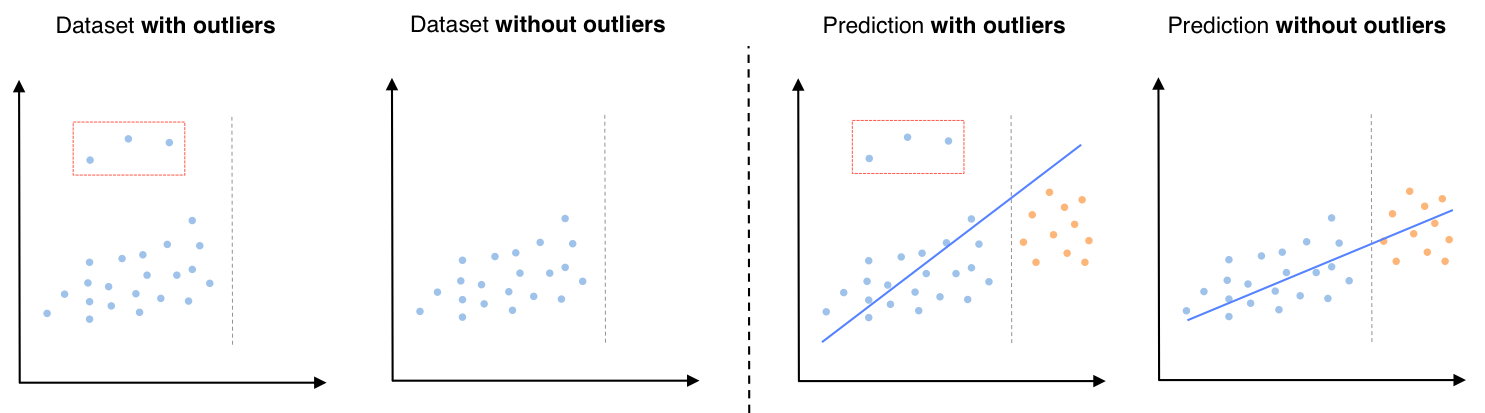

- We are dropping the outliers **only on the train set**.
- Why is that? We cannot touch the Kaggle test set otherwise the submission would not be accepted.
- A way to understand this is to consider the fact that we are training the algorithm on the training set only, threfore as long as the features are the same we are allowed to drop only some rows on the training set.
- Since this step requires you to provide the numerical features only, make sure you do this step after all the features types have been checked. It could be the case that some features were logged as string but are numerical and viceversa. If that is the case you need to rectify this.

In [ ]:
def get_cat_num_df(df):
    """Get categorical and numerical features name.

    Parameters
    ----------
    df : pandas dataframe

    Returns
    -------
    cat_cols : list
    num_cols : list    
    """

    cat_cols = df.select_dtypes(include=['object'])
    num_cols = df.select_dtypes(exclude=['object'])
    print(
        f'The dataset contains {len(cat_cols.columns.tolist())} categorical columns')
    print(
        f'The dataset contains {len(num_cols.columns.tolist())} numeric columns')

    return cat_cols, num_cols

In [ ]:
def detect_outliers(df, n, features, factor=1.5):
    """
    Takes a dataframe df and some features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.

    The outlier step was increased from 1.5 to 1.7 for better 
    performance.

    Parameters
    ----------
    df : pandas dataframe
    n : integer
        No of columns used to compute if the instance is an outlier for
        more than n features. This is an indication that it is more of an 
        outlier as this value is outside the range for more than one feature
    feature : list
    factor : float, default=1.5
        1.5 is the default used in the literature. Somtimes this it too restrictive
        and depending on the dataset used you may want to relax this by using a BIGGER value.

    Rerturns
    --------
    df : pandas dataframe

    References
    ----------
    https://en.wikipedia.org/wiki/Quartile
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = factor * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step)
                              | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

        #print("Feature:", col, " No found", len(outlier_list_col))

    # Establish how many time an entry is present
    # Example -> Counter({277: 3, 615: 3, 981: 3, 538: 3,
    outlier_indices = Counter(outlier_indices)
    multiple_outliers_index = list(
        k for k, v in outlier_indices.items() if v > n)
    print("No of outliers: ", len(multiple_outliers_index))
    return df.iloc[multiple_outliers_index], multiple_outliers_index

In [ ]:
cat_cols_train, num_cols_train = get_cat_num_df(train)
cat_cols_test, num_cols_test = get_cat_num_df(test)

In [ ]:
stop

- Even thought we are not dropping anything in the test data, we'd like to see the differences between the two datasets.
- We areusing factor = 2.0 and not the original 1.5 commonly used in the literature, jsut to limit the number of outliers being removed.

In [ ]:
num_cols_train.columns.drop("SalePrice")

In [ ]:
train_outliers, train_to_drop_index = detect_outliers(
    train, 2, num_cols_train, factor=1.7)
test_outliers, test_to_drop_index = detect_outliers(
    test, 2, num_cols_test, factor=1.7)

In [ ]:
train_outliers

In [ ]:
def compare_distribution_sets_on_numerical_columns(train, test):
    """
    
    Test if two each feature has the same distribution
    in both train and test set. This is achieved via a T-test. 
    To be able to perform this test we ONLY select the numerical 
    variables.
          
    Parameters
    ----------
    train : pandas dataframe
    test : pandas dataframe
    
    Returns
    -------
    dummy : pandas dataframe
    """

    # The reason why we get the test features is because we are sure
    # that every single feature is present in the train set and not viceversa
    # in fact, the target is not present in the test set
    numeric_features = test.dtypes[test.dtypes != object].index

    similar = []
    p_value = []
    mu, sigma = [], []
    min_test_within_train = []
    max_test_within_train = []
    
    for feature in numeric_features:

        # Getting rid of all null values. We are using zero as a form of imputation
        # but this was not a thought process in the sense that if you do not use it
        # throws you an error.
        train_clean = train[feature].fillna(0.0)
        test_clean = test[feature].fillna(0.0)

        stat, p = ttest_ind(train_clean, test_clean) 
        p_value.append(p)

        #print('Statistics=%.3f, p=%.3f' % (stat, p))
        alpha = 0.05
        if p > alpha:
            similar.append("similar")                
            #print('Same distributions (fail to reject H0)')
        else:
            similar.append("different")
            #print('Different distributions (reject H0)')
                
        min_train = get_IQR_frequency(pd.DataFrame(train_clean))["min"].values[0]
        min_test = get_IQR_frequency(pd.DataFrame(test_clean))["min"].values[0]
        
        max_train = get_IQR_frequency(pd.DataFrame(train_clean))["max"].values[0]
        max_test = get_IQR_frequency(pd.DataFrame(test_clean))["max"].values[0]
        
        #print("----",max_test <= max_train)
        
        min_test_within_train.append(min_test >= min_train)
        max_test_within_train.append(max_test <= max_train)
        

    # Create a pandas dataframe
    dummy = pd.DataFrame()
    dummy["numerical_feature"] =  numeric_features
    dummy["type"] = ["numerical" for _ in range(len(numeric_features))]
    dummy["train_test_similar?"] = similar
    dummy["ttest_p_value"] = p_value
    dummy["min_test>=min_train"] = min_test_within_train
    dummy["max_test<=max_train"] = max_test_within_train

    # Decorate the dataframe for quick visualisation
    def highlight(x):    
        return ['background: yellow' if v == "different" or v == False else '' for v in x]

    def bold(x):
        return ['font-weight: bold' if v == "different" or v == False else '' for v in x]

    # Visualise the highlighted df
    return dummy.style.apply(highlight).apply(bold)        

In [ ]:
def get_IQR_frequency(df):
    """Get the IQR or the frequency.
    
    This methos returns the interquartalies or the frquenecy
    depends on the feature beeing numerical or categorical.

    Parameters
    ----------
    df : pandas dataframe

    Returns
    -------
    dummy : pandas dataframe
        dummy storing IQR if numerical
        dummy storing the instance frequency if categorical
    """

    if all(df.dtypes != object):
        dummy = pd.DataFrame(df.describe()).T
    else:
        frequency = []
        frequency_percentage = []
        unique = list(set([i[0] for i in pd.DataFrame(df).values]))
        for i in unique:
            frequency.append(df[df == i].count()[0])
            frequency_percentage.append((df[df == i].count()[0]/len(df))*100)

        dummy = pd.DataFrame()
        dummy["Entries"] = unique
        dummy["Frequency"] = frequency
        dummy["Frequency[%]"] = frequency_percentage
        dummy.sort_values(by=['Frequency[%]'], inplace=True, ascending=False)

    return dummy

In [ ]:
# Just check if the situation has improved
compare_distribution_sets_on_numerical_columns(train, test)

In [ ]:
# Drop outliers
print("\nBEFORE:", train.shape)
train_ = train.drop(train_to_drop_index, axis = 0).reset_index(drop=True)
print("AFTER", train_.shape)

- **Attention** you cannot drop the outliers in the test data otherwise Kaggle will throw you an error.
- You can modify the feature but not the number of rows!

In [ ]:
# Drop outliers
print("\nBEFORE:", test.shape)
#test_ = test.drop(test_to_drop_index, axis = 0).reset_index(drop=True)
#print("AFTER", test_.shape)

- Just check if the situation has improved.
- Now we see that the situation has not improved. Why? Mainly because we are allowed to modified only the train set and not the test.
- **What solution do we have?** Skip this step of use a more representative test set. Something we cannot do here at Kaggle. What I mean is that you can still create a more presenative test set for your testing but you are still bound to use the Kaggle test set to submit a valid submission

In [ ]:
compare_distribution_sets_on_numerical_columns(train_, test)

In [ ]:
# Overwrite dataset
train = train_
#test = test_

_,_ = get_features_type(train)
_,_ = get_features_type(test)

## Sanity check on outliers removal

- We have used an automated procedure to get rid of the outliers. However keep in mind this:
    - The best one would be to check each feature one-by-one just to be sure it works
    - The idea of this subsection is to spot-check what we have done above for some of the value we have flagged under the `Features analysis` section .
    
- Further, please consider the following: Use entries removal only when you are 100% sure and this measn that automatic procedure are rarely robust. For small dataset even if the are flagged as outliers, removing them may be more detrimental than beneficial. One option could be just to make the model **robust** to them. Again, this become a matter of trial and errors.

**GrLivArea vs. SalePrice**

In [ ]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [ ]:
# Without log transform
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], 
           np.exp(train['SalePrice'])-1)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**OverallQual vs. SalePrice**

In [ ]:
fig, ax = plt.subplots()
ax.scatter(train['OverallQual'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

In [ ]:
# Without log transform
fig, ax = plt.subplots()
ax.scatter(train['OverallQual'], 
           np.exp(train['SalePrice'])-1)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

- It seems that our outliers algorithm removed most of the outstanding entries.
- However, this is an automated procedure and each feature should in theory at least visually be checked.

# Missing values

## General overview

- Bird high view of which feature has a non-usable value and how many of them are there.
- As always this is done for both train and test set, for the sole purpouse of understanding if the test is representative of the training set.
- Using heatmap to show the numeric data consisting missing value in train dataset. The white bars are representing missing value.

In [ ]:
plt.figure(figsize=(16, 5))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False);

In [ ]:
plt.figure(figsize=(16, 5))
sns.heatmap(test.isnull(), yticklabels=False, cbar=False);

## Missing non-numerical values

In [ ]:
# Missing TRAIN categorical values -> use mode (most common)
cat_cols_train_miss = cat_cols_train.columns[cat_cols_train.isnull().any()]
print(cat_cols_train_miss)

In [ ]:
# Missing TEST categorical values -> use mode (most common)
cat_cols_test_mis = cat_cols_test.columns[cat_cols_test.isnull().any()]
print(cat_cols_test_mis)

## Missing numerical values

In [ ]:
num_cols_train_mis = num_cols_train.columns[num_cols_train.isnull().any()]
num_cols_train_mis

In [ ]:
num_cols_test_mis = num_cols_test.columns[num_cols_test.isnull().any()]
num_cols_test_mis

## Further analysis

- Generally the threshold used to get rid of a features based on the number of missing values is anything in between **15 or 20%**.

In [ ]:
def get_missing_values(df, threshold=20, verbose=False, sort_by='No missing value'):
    """Get basic details of the dataset.

    Missing values and their percentage
    Unique values and their percentage (Cardinality)
    Cardinality is important if you are trying to understand
    feature importance.
    Type if numerical or not

    Parameters
    ----------
    threshold - float [percentage]
        Used to highlihgt in yellow value that have
        a number of missing entries greater than the
        threshold
    verbose - float 
        If set to True values on console

    Returns
    -------
    df_null_values : pandas dataframe

    """

    print("\nChecking NON usable data")
    print("Threshold set at [%]", threshold)
    zero = False
    for i in df.columns:
        if df[i].isnull().sum() > 0.0:
            zero = True
            if verbose == True:
                print("%s | No missing: %.2f | Percentage %.2f" %
                      (i, df[i].isnull().sum(), df[i].isnull().mean()*100))

    if zero == False:
        print("No null values found!")

    # Pandas dataframe of the same print out shown above
    b = pd.DataFrame()
    b['No missing value'] = df.isnull().sum()
    b["Missing[%]"] = df.isna().mean()*100
    b['dtype'] = df.dtypes

    # Turn index into a columns
    b['Feature'] = b.index
    # Getting rid of the index
    b.reset_index(drop=True, inplace=True)
    # Order the entries, larger first

    b.sort_values(by=[sort_by], inplace=True, ascending=False)
    # Move feature as first column
    b = b[['Feature'] + [col for col in b.columns if col != 'Feature']]
    df_null_values = b

    # Highlihgt values > threshold)
    def highlight(x):
        return ['background: yellow' if v > threshold else '' for v in x]

    def bold(x):
        return ['font-weight: bold' if v > threshold else '' for v in x]

    # Visualise the highlighted df
    return df_null_values.style.apply(
        highlight, subset=["Missing[%]"]).apply(bold, subset=["Missing[%]"])

In [ ]:
def plot_missing_values(df, threshold = 20):
    rcParams['font.size'] = 15
    plt.figure(figsize=(12, 10))
   
    #dummy = (df.loc[:, df.isnull().any()].isna().sum() / df.shape[0]).sort_values()
    #dummy.plot(kind='barh')
    missing = round(df.isnull().mean()*100,2)
    missing = missing[missing > 0]    
    missing.sort_values().plot(kind='barh')

    plt.axvline(x=threshold, color='r', linestyle='-', lw=4, label='Reference line')
    plt.legend()
    plt.xlabel('% of missing data', size=25)
    plt.show()

In [ ]:
df_train_null_values = get_missing_values(train, threshold=20, verbose=False)

In [ ]:
df_train_null_values

In [ ]:
plot_missing_values(train)

In [ ]:
# Checking null value in test set
df_test_null_values = get_missing_values(test)

In [ ]:
df_test_null_values

In [ ]:
plot_missing_values(test)

- **PoolQC**: Pool quality
- There is another feature related to Pool which is `PoolArea`. This is important because if we decide to drop `PoolQC` on the ground that there are too many value missing, would it make sense to leave `PoolArea` there?
- From the plot below we can see that how most of the entries under `PoolArea` have zero assigned to them. This means we can use this to impute some of the missing value of `PoolQC`. This is to say that whenevere, `PoolArea` is zero the corresponding `PoolQC` should be impute a value equal to 0.0 if not provided. This is a robust way of proceeding because `PoolArea` does not have any missing values so we should be able to use this to drive the imputation.

- **MiscFeature**: Miscellaneous feature not covered in other categories       
- Even if we were able to impute the missing value, how useful is this feature would be? I can see one of the entry
has value `Othr` which  I do not think is very informative.
- Our second problem is how we could impute this feature? I do not see any easy way of impute this one. So, I'd would suggest droppoing this feature.
- One other option, could be to use NA for all null value, but considering the already very big encoded features, with the subsequent increase in column, I'd rather not to this.

- **Alley**: Type of alley access to property
- Option No1 = Impute value based on other feature. Not possible as none of the other features provide a clue on how to do it.
- Option No2 = Assume the non usable entries are essentially `NA` which would make sense
- Option No3 - Drop the feature.
- I'd go for option No2. In any case, this feature can be dropped if found not be correlated with the output.

- **Fence**: Fence quality    
- Option No1 = Impute value based on other feature. Not possible as none of the other features provide a clue on how to do it.
- Option No2 = Assume the non usable entries are essentially NA which would make sense
- Option No3 - Drop the feature.
- I'd go for option No2. In any case, this feature can be dropped if found not be correlated with the output.

- **FireplaceQu**: Fireplace quality   
- Option No1 = Impute value based on other feature. This can be achieve by looking at `Fireplaces` which does not have any mising values and it is a good candidate to do wxactly what we lay out for `PoolQu`
- Option No2 = Assume the non usable entries are essentially NA which would make sense
- Option No3 - Drop the feature.
- I'd go for option No1 as it is more elegant and justifiable than Option No2.

In [ ]:
def remove_feature_on_null_values(df, threshold=20, columns = [], method="by_list"):
    """Remove features
    
    Remove features based on dataframe threshold
    
    Paramereters
    ------------
    df : pandas dataframe
    
    threshold : float, default=20
        Use to drop column/feature/explainer
        
    columns : list of string, default=[]
    
    method : string
        It takes two values
        by_threshold (columns is ignores) and each feature that
        has a number of missing value higher that what indicated by
        the threshold parameters
        
        by_list (threshould is ingnored) and only the features in 
        the columns list are dropped
            
    Returns
    -------
    df - pandas dataframe
        The new dataframe withouth the dropped features.
    """

    print("\nShape BEFORE", df.shape)    
    df = copy.deepcopy(df)
    
    if method == "by_threshould":
        print("Removing feature/column/explainer")
        print("Threshold set at [%]", threshold)
        drop_features = []
        for i in df.columns:
            if df[i].isnull().sum() > 0.0:
                if df[i].isnull().mean()*100 > threshold:
                    drop_features.append(i)

        print("Dropping columns", drop_features)    
        #df.columns(columns=drop_features)
        df = df.drop(drop_features, axis=1, inplace=True)
    
    elif method == "by_list":
        print("Removing feature/column/explainer")
        print("Coumns to be dropped", columns)
        for to_drop in columns:
            df.drop(columns = [to_drop], axis=1, inplace=True)
        
    print("Shape AFTER", df.shape)

    
    return df

In [ ]:
# Remove features/columns/explainers if missing is more than 20%
# Please note that this makes sense only if both train and test
train_ = remove_feature_on_null_values(
    train, columns=["MiscFeature"], method="by_list")
test_ = remove_feature_on_null_values(
    test, columns=["MiscFeature"], method="by_list")

In [ ]:
# Overwriting the sets
train = train_
test = test_

In [ ]:
_,_ = get_features_type(train)
_,_ = get_features_type(test)

# Data imputation

- Now it is time to actually impute the missing data. We jsut have to decide if we want to merge and impute or if we proceed wit it on two separate dataset. **Why does it make sense to ask this question?**
- We have three sets:
    - **training** = provided by Kaggle for you to train your model
    - **test** = peovided and used by Kaggle to score you on the leaderboard
    - **test** (another one and different from the one give to you) = used by Kaggle to score you in the private board. This is done at the end of each competition. 

- Now consider this case: if use the mean or median to imput a missing value where is this value coming from. If we use the merged dataset (train+test) it means some info from a test set is leaking to the training set. Now if the distributino are exactly the same these would not change much, otherwise we are leaking ssomething from test to train set. If a leak is there and how much it would affect the result needs to be etablished on case basis.

- Further, if there is a leak what would be the effect on the private set? This cannot be established because we do not have access to that set. 

- At the end of the date for this dataset, I would expect a difference to be there between merged and not merged set impputation and the only way we have to find out is to run a test.

- At this point the message is the following:
    - Use mean if the feature are not too skewed
    - Use median if the feature is skewed
    - Whereever neitehr the mean nor the median makes sense, then read the `data_description.txt` and use a customised imputation strategy.

| **Type**                            | Description |
| ----------------------------------- | ----------------- |
| Missing Completely At Random (MCAR) | Values in a data set are Missing Completely At Random (MCAR) if the events that. | lead to any particular data-item being missing are independent both of observed data and of missing data.                |
| Missing At Random (MAR)             | When the missing data is related to the observed data but not the missing data. |
| Missing Not At Random (MNAR)        | When the data is neither MAR nor MCAR. The missing values on the variable are related to that of both the observed and missing variables. |

- Other techniques (comprehensive list) can be check out in this [reference](https://www.kaggle.com/srivignesh/techniques-for-handling-the-missing-data)

In [ ]:
_,a = get_features_type(train)
_,b = get_features_type(test)

In [ ]:
a.columns

In [ ]:
b.columns

In [ ]:
def data_imputation(df):
    """Data impputation.

    Paramaters
    ----------
    df : pandas dataframe

    Returns
    -------
    df : pandas dataframe
    """

    df = copy.deepcopy(df)

    # MSSubClass
    """
    Numeric-> treated as categorical. train and test do not have the same
    entries! No need for data imputation
    """

    # MSZoning
    """
    Option No1 -> hard coded value
    Option No2 -> use mode -> most common value
    Option No3 -> group by the MSSubClass, and fill in missing values by the MSZoning mode of the MSSubClass
    """
    #df['MSZoning'] = df['MSZoning'].fillna("A")
    df["MSZoning"] = df["MSZoning"].fillna(df["MSZoning"].mode()[0])
    #df['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    # LotFrontage
    """
    Option No1 -> use median -> second quantile -> 50% percentile
    Option No2 -> use mean, not suggest as distribution is skewed!
    Option No3 -> group the by neighborhoods, and fill in missing value 
                  by the median LotFrontage of all the neighborhood.
                  Since the area of each street connected to the house property 
                  most likely have a similar area to other houses in its neighborhood, 
                  we can fill in missing values by the median LotFrontage of the neighborhood.
    """
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    #df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
    #df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # LotArea -> No missing values -> No action
    # Street -> No missing values -> No action

    # Alley
    """
    Option No1 -> consider nan as a real one and drop the row
    Option No2 -> consider nan as an entry for NA (No alley access)-> preferred
    """
    df['Alley'] = df['Alley'].fillna("NA")

    # LotShape -> No missing values -> No action
    # LandContour -> No missing values -> No action

    # Utilities
    """
    Option No1 -> consider nan as a real one and drop the row
    Option No2 -> use the mode -> most common value
    """
    df["Utilities"] = df["Utilities"].fillna(df["Utilities"].mode()[0])

    # LotConfig -> No missing values -> No action
    # LandSlope -> No missing values -> No action
    # Neighborhood -> No missing values -> No action
    # Condition1 -> No missing values -> No action
    # Condition2 -> No missing values -> No action
    # BldgType -> No missing values -> No action
    # HouseStyle -> No missing values -> No action
    # OverallQual -> No missing values -> No action
    # OverallCond -> No missing values -> No action
    # YearBuilt -> No missing values -> No action
    # YearRemodAdd -> No missing values -> No action
    # RoofStyle -> No missing values -> No action
    # Roof material -> No missing values -> No action

    # Exterior1st & Exterior2nd -> used mode
    df["Exterior1st"] = df["Exterior1st"].fillna(df["Exterior1st"].mode()[0])
    df["Exterior2nd"] = df["Exterior2nd"].fillna(df["Exterior2nd"].mode()[0])

    # MasVnrType
    """
    Option No1 -> use None
    Option No2 -> use the most common -> not suggested
    """
    df['MasVnrType'] = df['MasVnrType'].fillna("None")

    # MasVnrArea
    """
    Option No1 -> fill with zero but this is likely to be plain wrong!
    Option No2 -> use mean but keep in mind the dsitribution is skewed
    Option No3 -> use median -> it is zero so it cannot be used
    """
    df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())

    # ExterQual -> No missing values -> No action
    # ExterCond -> No missing values -> No action
    # Foundation -> No missing values -> No action

    # BsmtQual & BsmtCond -> use NA no basement
    df['BsmtQual'] = df['BsmtQual'].fillna("NA")
    df['BsmtCond'] = df['BsmtCond'].fillna("NA")

    # BsmtExposure -> use NA -> No Basement
    df['BsmtExposure'] = df['BsmtExposure'].fillna("NA")

    # BsmtFinType1 & BsmtFinType2-> use NA -> No Basement
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna("NA")
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna("NA")

    # BsmtFinSF1 & BsmtFinSF2 -> use 0.0 as in no basement
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0.0)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0.0)

    # BsmtUnfSF -> use median
    df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].median())

    # TotalBsmtSF -> use median
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].median())

    # Heating -> No missing values -> No action
    # HeatingQC -> No missing values -> No action
    # CentralAir -> No missing values -> No action

    # Electrical -> use mode
    df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

    # 1stFlrSF -> No missing values -> No action
    # 2ndFlrSF -> No missing values -> No action
    # LowQualFinSF -> No missing values -> No action
    # GrLivArea -> No missing values -> No action

    # BsmtFullBath -> fill with zero
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0.0)

    # BsmtHalfBath -> fill with zero
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0.0)

    # FullBath -> No missing values -> No action
    # HalfBath -> No missing values -> No action

    # KitchenQual -> use TA -> Typical/Average
    df['KitchenQual'] = df['KitchenQual'].fillna("TA")

    # TotRmsAbvGrd -> No missing values -> No action

    # Functional
    """
    The data description states to assume typical unless deductions are warranted
    We can interpret this as use Typ for NaA values. Here, we'd use the
    mode (most common) which coincide with "Typ". This can be deducted from the 
    feature-by-feature analysis done above.
    """
    df["Functional"] = df["Functional"].fillna(df["Functional"].mode()[0])

    # Fireplaces -> No missing values -> No action

    # FireplaceQu
    """
    Use NA when No Fireplace == 0.0. Essentially we are using another feature
    to impute the missing value. This is robust way of proceeding.
    """
    for i in df["FireplaceQu"][pd.isna(df["FireplaceQu"])].index:
        if df["Fireplaces"].iloc[i] == 0.0:
            df["FireplaceQu"].iloc[i] = "NA"

    # GarageType -> use NA -> No Garage
    df["GarageType"] = df["GarageType"].fillna("NA")

    # GarageYrBlt
    """
    Option No1 -> use mean but feature are skewed
    Option No2 -> use median to take into account how feature is skewed
    Option No3 group by some feature and try to get the value from a
    similar feature that has no null values in it.
    """
    df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["GarageYrBlt"].median())

    # GarageFinish -> use NA -> No Garage
    df["GarageFinish"] = df["GarageFinish"].fillna("NA")

    # GarageCars -> use 0.0
    df["GarageCars"] = df["GarageCars"].fillna(0.0)

    # GarageArea -> use 0.0
    df["GarageArea"] = df["GarageArea"].fillna(0.0)

    # GarageQual -> use NA
    df["GarageQual"] = df["GarageQual"].fillna("NA")

    # GarageCond -> use NA
    df["GarageCond"] = df["GarageCond"].fillna("NA")

    # PavedDrive -> No missing values -> No action
    # WoodDeckSF -> No missing values -> No action
    # OpenPorchSF -> No missing values -> No action
    # EnclosedPorch -> No missing values -> No action
    # 3SsnPorch -> No missing values -> No action
    # ScreenPorch -> No missing values -> No action
    # PoolArea -> No missing values -> No action

    # PoolQC
    """
    From the plot below we can see that how most of the entries under `PoolArea` have zero 
    assigned to them. This means we can use this to impute some of the missing value of 
    `PoolQC`. This is to say that whenevere, `PoolArea` is zero the corresponding `PoolQC` 
    should be impute a value equal to NA if not provided. For all the situation where the
    PoolQC is missing and the PoolArea is not zero then use the "TA" as in average/Typical
    just to stay on the conservative side of things.
    """
    for i in df["PoolQC"][pd.isna(df["PoolQC"])].index:
        if df["PoolArea"].iloc[i] == 0.0:
            df["PoolQC"].iloc[i] = "NA"
        else:
            # Use TA Tipycal/Average
            df["PoolQC"].iloc[i] = "TA"

    # Fence -> use NA for no pool
    df["Fence"] = df["Fence"].fillna("NA")

    # MiscFeature -> feature was dropped
    #df["MiscFeature"] = df["MiscFeature"].fillna("NA")

    # MiscVal -> No missing values -> No action
    # MoSold -> No missing values -> No action
    # YrSold -> No missing values -> No action

    # SaleType -> Use mode
    df["SaleType"] = df["SaleType"].fillna(df["SaleType"].mode()[0])
    # SaleCondition -> No missing values -> No action

    return df

In [ ]:
# Impute the data
train_ = data_imputation(train)
test_ = data_imputation(test)

In [ ]:
# Sanity check
_,_ = get_features_type(train_)
_,_ = get_features_type(test_)

In [ ]:
# Overwriting our current sets
train = train_
test = test_

- Check again that no missing values are present.

In [ ]:
get_missing_values(train_, 0.0,
                   sort_by="Feature")

In [ ]:
get_missing_values(test_, 0.0,
                   sort_by="Feature")

# Skewed features

- This step step is performed **after* the data imputation. The rationale is the following. If we have to establih how skew a feature is we'd better do so after imputation as the imputation itself may skew the feature later. I guess this is a rare case, but it's just to be on the safe side.
- The alternative is to impute before the data imputation step. It did not seem right to me, but I have not tried it here, so my approach my be plain wrong.


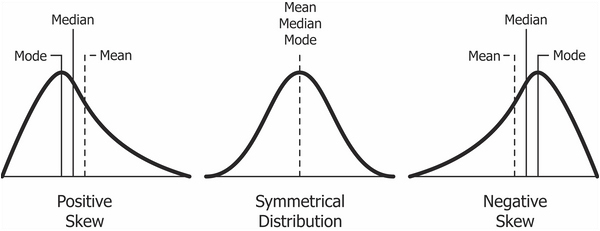

- **WARNING** How robust are these data when there are a lot of zeros?
- In this example, using the classical skew and kurtois may leas to some surprising results. Such as, data being declared normal when they do not like that.
- What I've done here was to manually remove the zero so "force" to make it work. This is by no-means a scientific approach and I'd like to know what other approach others have used.
- References:
    - https://stats.stackexchange.com/questions/540712/if-i-have-data-that-appears-normally-distributed-but-it-contains-a-lot-of-zeros
    - https://www.researchgate.net/publication/314032599_TO_DETERMINE_SKEWNESS_MEAN_AND_DEVIATION_WITH_A_NEW_APPROACH_ON_CONTINUOUS_DATA
    - https://www.researchgate.net/post/How-can-I-analyze-variables-with-several-zeros

In [ ]:
def test_set_for_normality(df, order_by="numerical_feature"):
    """Test det for normality.
    
    Check if a distribution is normal via Shapiro test. 
    In practice the shapiro-p value is reported but not used
    because it is badly affected if the sample are too large!
    We'll use the kurtois and skew factors to establish if it is
    normal or not
          
    Parameters
    ----------
    df : pandas dataframe    
    order_by : string, default="numerical_feature"
        Name of the feature used to order the entries
    
    Returns
    -------
    df - pandas dataframe
    
    References
    ----------
    https://www.researchgate.net/post/P-value-equal-to-0000-in-every-test-how-is-it-possible
    """

    numerical_features = df.dtypes[df.dtypes != object].index    
    
    mu, sigma = [], []
    normal_pvalue = []    
    normal = []
    skew_all = []
    kurtois_all = []
    for feature in numerical_features:
        # Getting rid of all null values. We are using zero as a form of imputation
        # but this was not a thought process in the sense that if you do not use it
        # throws you an error.
        df_clean = df[feature] #.fillna(0.0)
        
        """
        Further we removing all value that equal to zeros
        """
        #df_clean = df_clean[df_clean.values != 0]
        
        
        df_clean = df_clean     
        #print(feature)
        
        # Shapiro normality test for TRAIN dataset
        shap = stats.shapiro(df_clean)        
        normal_pvalue.append(shap.pvalue)
        skew = df_clean.skew()
        skew_all.append(skew)
        kurtois = df_clean.kurt()
        kurtois_all.append(kurtois)     
        
        condition_No1 = skew < 0.5 and skew > -0.5
        condition_No2 = kurtois < 2.0 and kurtois > -2.0
        # We use or instead of and because the end would be too stringent
        if condition_No1 or condition_No2:
            normal.append("normal")            
        else:
            normal.append("not_normal")        

    # Create a pandas dataframe
    dummy = pd.DataFrame()
    dummy["numerical_feature"] =  numerical_features    
    dummy["type"] = ["numerical" for _ in range(len(numerical_features))]    
    dummy["shapiro_pvalue"] = normal_pvalue    
    dummy["skew"] = skew_all
    dummy["kurtois"] = kurtois_all
    dummy["normal?"] = normal

    # Decorate the dataframe for quick visualisation
    def highlight(x):    
        return ['background: yellow' if v == "different" or v == "not_normal" else '' for v in x]

    def bold(x):
        return ['font-weight: bold' if v == "different" or v == "not_normal" else '' for v in x]

    dummy.sort_values(by=[order_by], inplace=True, ascending=True)
    # Visualise the highlighted df
    return dummy.style.apply(highlight).apply(bold)        

In [ ]:
test_set_for_normality(train, order_by="skew")

In [ ]:
test_set_for_normality(test, order_by="skew")

- We can also try to visualise this with a bar plot.
- Please note that we have used a log y-scale to easily compare all the features.

In [ ]:
def plot_box_plot(df, num_features):
    # Create box plots for all numeric features
    f, ax = plt.subplots(figsize=(15, 9))
    ax.set_yscale("log")
    ax = sns.boxplot(data=df[num_features.columns] , orient="v", palette="Set1")
    #ax.xaxis.grid(False)
    ax.set(xlabel="Feature names")
    ax.set(ylabel="Numeric values")
    ax.set(title="Numeric Distribution of Features")
    plt.xticks(rotation=90)
    sns.despine(trim=True, left=True)

In [ ]:
plot_box_plot(train, num_cols_train)

In [ ]:
plot_box_plot(test, num_cols_test)

In [ ]:
def get_skewed_features(df):
    """Test det for normality.
    
    Check if a distribution is normal via Shapiro test. 
    In practice the shapiro-p value is reported but not used
    because it is badly affected if the sample are too large!
    We'll use the kurtois and skew factors to establish if it is
    normal or not
          
    Parameters
    ----------
    df - pandas dataframe    
    
    Returns
    -------
    df - pandas dataframe
    
    References
    ----------
    https://www.researchgate.net/post/P-value-equal-to-0000-in-every-test-how-is-it-possible
    """
    
    numerical_features, non_numerical_features = get_features_type(df)
    numerical_features = numerical_features.columns
    
    mu, sigma = [], []
    normal_pvalue = []    
    normal = []
    skew_all = []
    kurtois_all = []
    for feature in numerical_features:
        # Getting rid of all null values. We are using zero as a form of imputation
        # but this was not a thought process in the sense that if you do not use it
        # throws you an error.
        df_clean = df[feature].fillna(0.0)        

        # Shapiro normality test for TRAIN dataset
        shap = stats.shapiro(df_clean)        
        normal_pvalue.append(shap.pvalue)
        skew = df_clean.skew()
        skew_all.append(skew)
        kurtois = df_clean.kurt()
        kurtois_all.append(kurtois)
        condition_No1 = skew < 0.5 and skew > -0.5
        condition_No2 = kurtois < 2.0 and kurtois > -2.0
        if condition_No1 and condition_No2:
            normal.append("normal")            
        else:
            normal.append("not_normal")        

    # Create a pandas dataframe
    dummy = pd.DataFrame()
    dummy["numerical_feature"] =  numerical_features    
    dummy["type"] = ["numerical" for _ in range(len(numerical_features))]    
    dummy["shapiro_pvalue"] = normal_pvalue    
    dummy["skew"] = skew_all
    dummy["kurtois"] = kurtois_all
    dummy["normal?"] = normal
    
    skewed_features = dummy[dummy["normal?"] == "not_normal"]["numerical_feature"].values
    print("No of skewed features: ", len(skewed_features))
    return skewed_features

In [ ]:
skewed_train_features = get_skewed_features(train)
skewed_test_features = get_skewed_features(test)

In [ ]:
skewed_train_features

In [ ]:
skewed_test_features

- Get the uncommon features!
- As you can seen there are two feautures that do not share the same distribution. This could have been highlighted also by looking at the normality test done ealier.
- Further if had merged the dataset we'd have poised the well by leaking this type of information.
- In theory, nobody is stopping you from doing it, but your leaderboard score could be very different from the score achieved on the private board.

In [ ]:
print(set(skewed_train_features) - set(skewed_test_features))
print(set(skewed_test_features) - set(skewed_train_features))

- At this point we have a list of highly skewed features and we need to decide what do with it.
    - **Option No1** apply a log transform but that would work only for striclty positive features. In our cases all the skewed feature a positively skewed so we can still use this option.
    - **Option No2** apply a BoxCox transform, which can be applied also to negative values.

- **WARNING**. We created a method to selected all those features that are skewed. However, this method uses kurtossis and skewed factor to  establish if a feature is normally distributed or not. 
- At this point we can see that feature `TotalBsmtSF` is not been tagged as skewed although it is. The reason for these fealure is due to the fact that there are too many zeros.
- In order to take care of this, we'll manually add this and all the other that are not capture.

In [ ]:
skewed_train_features = np.append(skewed_train_features, "TotalBsmtSF")
skewed_train_features

In [ ]:
def log_transform(df, skew_index = [], log_all="none"):
    """Log transform the data.

    Options:
    all = log all the numerical features
    none = log nothing and returns original dataset
    only = only some highly skew data    
    """
    # """

    import copy
    df = copy.deepcopy(df)

    """
    we'd like to applies the transformation in all the value but not those that have zeros.
    """    

    if log_all == "all":
        numerical_features = df_not_zeros.dtypes[df_not_zeros.dtypes != object].index
        for i in numerical_features:
            df_not_zeros = df[i][df[i] > 0.0]                
            df_not_zeros = np.log1p(df_not_zeros)
            df[i][df[i] > 0.0] = df_not_zeros
    elif log_all == "only":
        for i in skew_index:
            #print(i)
            #print(df[i][df[i] > 0.0])            
            df_not_zeros = df[i][df[i] > 0.0]          
            df_not_zeros = np.log1p(df_not_zeros)   
            df[i][df[i] > 0.0] = df_not_zeros
    elif log_all == "none":
        pass

    
    return df

- We use the scipy function `boxcox1p` which computes the Box-Cox transformation of 1+x.
- `λ` is the power parameter. **Note that** setting `λ=0` is equivalent to log1p used above for the target variable. - [reference](https://onlinestatbook.com/2/transformations/box-cox.html).
- How do we chose the optimal value of lambda? 
    - Use `scipy.stats.boxcox()` which will return the Box-Cox transformed array and the optimal value for lambda 
    [link](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook).
    - Use `scipy.stats.boxcox_normmax` which compute optimal Box-Cox transform parameter for input data. [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox_normmax.html)


In [ ]:
def box_cox_transform(df, skew_index, log_all = "none"):
    """Log transform the data.
    
    Options:
    all = log all the numerical features
    none = log nothing and returns original dataset
    only = only some highly skew data
    """
    #"""
    import copy
    df= copy.deepcopy(df)
    
    if log_all == "all":
        numerical_features = df.dtypes[df.dtypes != object].index         
        for i in numerical_features:                
            df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))
    elif log_all == "only":
        for i in skew_index:            
            #df[i] = np.lg1p(df[i])
            df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))
    elif log_all == "none":
        pass

    return df

- We'll start with the log-transform and see how it worked.
- You can see that for some features, even though the skew and kurtois values were changed, this was not enough to nromalise the feature.
- Can the BoxCox do better? As you can see from the analysis below there are cases where one is better than the other and probably the best way to proceed, would be to test different method in a loop and check how close the get to the normal distribution.
- In this case, we'll lazily chose method 1: log transform.

In [ ]:
# Normalise high feature that have a high skew factor using log_transformation
TRAIN_1 = log_transform(train, skewed_train_features, log_all="only")
TEST_1 = log_transform(test, skewed_test_features, log_all="only")

In [ ]:
# Normalise high feature that have a high skew factor using box_cox_transformation
TRAIN_2 = box_cox_transform(train, skewed_train_features, log_all="only")
TEST_2 = box_cox_transform(test, skewed_test_features, log_all="only")

In [ ]:
test_set_for_normality(train)

In [ ]:
test_set_for_normality(TRAIN_1)

In [ ]:
test_set_for_normality(TEST_1)

In [ ]:
test_set_for_normality(TEST_2)

- This comparison show that box-cox transform is **better** than the log tranform.
- Let us now visualise some of the feature that were transformed.

In [ ]:
skewed_train_features

- We'll now simply verify that the traansformation has worked.
- Has you can see if we filtered out the zero value the distribution looks normal (or at least an improvement).
- We'll first compare features manually then we'll do the same in a loop for all features and both methods.

In [ ]:
def compare_QQ_kde(distr1, distr2):
    """Compare QQ and DKE plot.

    Parameters
    ----------
    distr1 : pandas.core.series.Series
    distr2 : pandas.core.series.Series

    Returns
    -------
    None
    """
    
    #distr1 = [i[0] for i in distr1]
    #distr2 = [i[0] for i in distr2]

    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    fig.suptitle(" qq-plot & distribution: original vs. log-transform ", fontsize=15)

    # SalePrice BEFORE transformation
    #sm.qqplot(distr1, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0, 0])
    stats.probplot(distr1, plot=ax[0, 0])
    sns.distplot(distr1, kde=True, hist=True, fit=norm, ax=ax[0, 1])
    

    # SalePrice AFTER transformation
    #sm.qqplot(distr2, stats.t, distargs=(4,), fit=True, line="45", ax=ax[1, 0])
    stats.probplot(distr2, plot=ax[1, 0])
    sns.distplot(distr2, kde=True, hist=True, fit=norm, ax=ax[1, 1])
    plt.show()

In [ ]:
compare_QQ_kde(train['TotalBsmtSF'], TRAIN_1['TotalBsmtSF'][TRAIN_1['TotalBsmtSF']>0.0])

In [ ]:
compare_QQ_kde(train['TotalBsmtSF'], TRAIN_2['TotalBsmtSF'][TRAIN_2['TotalBsmtSF']>0.0])

In [ ]:
compare_QQ_kde(TRAIN_1['PoolArea'], TRAIN_2['PoolArea'])

In [ ]:
train["GarageYrBlt"]

In [ ]:
TRAIN_2['GarageYrBlt']

In [ ]:
compare_QQ_kde(TRAIN_1['GarageYrBlt'], TRAIN_2['GarageYrBlt'])

- In the cell below we just want to plot all the feature that were transformed.
- We do this in a loop for both the log-transform and the Box-Cox one where:
    - `TRAIN_1` corresponds to the log transform
    - `TRAIN_2`corresponds to the Box-Cox transform
- This allows us to see the differences between the two options.

In [ ]:
for temp in skewed_train_features:
    print("*************")
    print(temp)
    print("*************")
    compare_QQ_kde(train[temp], TRAIN_1[temp])

In [ ]:
for temp in skewed_train_features:
    print("*************")
    print(temp)
    print("*************")    
    try: 
        compare_QQ_kde(train[temp], TRAIN_2[temp])
    except:
        print("Could plot this feature:", temp)
        pass

- As we can see there are some difference between the two trasnformation.
- We'll use the Box-Cox transform instead of the log because it is just more flexible and robust.
- For some reason the Box-Cox transform failed on `GarageYrBlt`, see for yourself on `TRAIN_2['GarageYrBlt']` and pay attention to the scale!

In [ ]:
train = TRAIN_1
test = TEST_1

In [ ]:
plot_box_plot(train, num_cols_train)

In [ ]:
plot_box_plot(test, num_cols_test)

In [ ]:
# Routine check on the dimensions
_,_ = get_features_type(train)
_,_ = get_features_type(test)

In [ ]:
compare_distribution_sets_on_numerical_columns(train, test)

In [ ]:
skewed_train_features

## A note on homoscedasticity

- The best approach to test **homoscedasticity** for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).
- Older versions of this scatter plot (previous to log transformations), had a conic shape see. As you can see, the current scatter plot doesn't have a conic shape anymore. That's the power of normality! Just by ensuring normality in some variables, we solved the homoscedasticity problem.


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(train['GrLivArea'], train['SalePrice'])
ax.set_xlabel("GrLivArea")
ax.set_ylabel("SalePrice")

- In here the only thing we have to keep in mind is our discussion about the zero entries, before the log transform.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(train['TotalBsmtSF'][train["TotalBsmtSF"] > 0],
            train['SalePrice'][train["TotalBsmtSF"] > 0])
ax.set_xlabel("GrLivArea")
ax.set_ylabel("SalePrice")

# Feature engineering

- This step can be done before feature selection or after.
- At the end of the day, like any other things in data science, it is done in a loop. Pretty much on a trias and erros basis.
- After we add this feature, we'll then look at the correlation to double check if what we add is indeed correlated with the output.
- One of the thing we need to establish is whether to use the column as a categorical or numerical one. Generally the challenge is establishing if a numerical must be used as a categorical or not. When a variable is a string the choice is pretty straighforward. The graph reported below can help us in this analys (taken from Stevens, Eli, Luca Antiga, and Thomas Viehmann. Deep learning with PyTorch. Manning Publications Company, 2020)

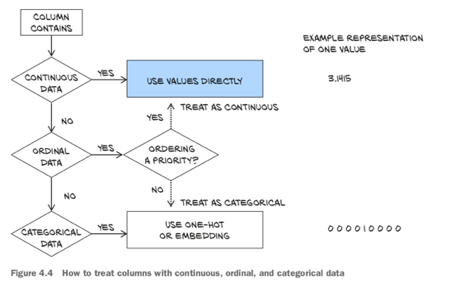

- A note on the efficieny of this method.
- Once may be wondering why I have not grouped certain action together in order to reduce the amount of code.
- The reason for this is that this was built step-by-step along with method `Features analysis`. After each feature was analysed, I would come here under `fearures_engineering` method and add the corresponding code.

- **Can we be sure that each numerical candidate is indeed a numerical feature?** A feature that measures the area is a numerical feature but what about MSSubClass? It holds different groups as is not numerical but rather categorical. A first attempt to crate flag capable of warning us of this could be to assume that if a feaure is relly a numerical features then should have various different values and not only a few. Essentially we could check for the cardinality?
- Features that count the number of rooms. This seems to be more categorical as you can't have 3.245 bedrooms for example. The same holds for the number of fireplaces and garage cars.
- Features like OverallCond and OverallQual can be considered as groups and are categorical variables with a natural kind of order (ordinal features).
- Every feature with SF or area can be considered as numerical.
- I think that we should treat temporal features like YrSold as categorical.

- Credit to this [reference](https://www.kaggle.com/allunia/house-prices-tutorial-with-catboost)

In [ ]:
train["GarageYrBlt"]

In [ ]:
def features_engineering(df, how="None"):
    """Feature engineering.

    This is the method feaure are either addded, removed
    or transformed accordingly to some criteria defined
    by the data scientist. To facilate the reading I have
    kept the order as it the one in the data_description.txt
    file.

    Paramaters
    ----------
    df : pandas dataframe
        This is the original dataframe.
    how : string
        basics : this perform the basics feature engineering
        other : define on a custom base

    ReturnsExte
    -------
    df : pandas dataframe
        A modified version of the original df after some changes
        as detailed below.
    """

    print("Feature engineering")
    print("Shape BEFORE", df.shape)
    print("\n")
    df = copy.deepcopy(df)
    
    cat_feature = []

    # MSSubClass
    cat_feature.append("MSSubClass")
    # ************************************************************************
    """
    Numeric -> from float to string -> treated as categorical.
    We have done this step earlier under section "Minimal amount
    of feature engineering".
    Please note that train and test do not have the same entries, in parituclar
    the test set has an additional entry (150) not present in the TRAIN set. So,
    if we had merged the dataset we'd have leaked this info into the TRAIN set.
    The painstaking job we did on Step_#2 pay off by warning us of this possibility.
    However, this is a competition and yes we are going to leak this info, but at 
    least we are aware of this.    
    
    AT IMPORTAMT obeservation: by adding 150 into our encoding, we are adding
    an extra column, however, since train and test are still split we are not
    adding a 1 so the TRAIN set is still not seeing 150! Does this account to
    data leakage? I am still not sure about the answer!
    """

    categories = ['160', '70', '40', '75', '190', '45', '80',
                  '50', '20', '85', '180', '150', '120', '90', '60', '30']
    onehot_encoder = OneHotEncoder(
        handle_unknown="error", sparse=False, categories=[categories])  # .reshape(-1,1))

    onehot_encoder.fit(df["MSSubClass"].values.reshape(-1, 1))

    df["MSSubClass"] = onehot_encoder.transform(
        df["MSSubClass"].values.reshape(-1, 1))

    #df = pd.get_dummies(df, columns=["MSSubClass"], prefix="MSSubClass")

    dummy = "MSSubClass"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))
    
    """
    This would have been the code if we had decided to use
    label encoding
    lbl = LabelEncoder()
    lbl.fit(list(df["MSSubClass"].values))
    df["MSSubClass"] = lbl.transform(list(df["MSSubClass"].values))
    """

    # MSZoning
    cat_feature.append("MSZoning")
    # ************************************************************************
    """
    Use one-hot encoding
    """
    df = pd.get_dummies(df, columns=["MSZoning"], prefix="MSZoning")
    dummy = "MSZoning"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet, had we wanted ordinal label encoding
    Also note that not all the entries reported in the description are
    used because there were no instances.
    MSZoning_map = {'FV':1, 'RL':2, 'RM':3, 'RH':4, 'C (all)':5}
    df['MSZoning'].replace(MSZoning_map, inplace=True)
    """

    # LotFrontage -> no action but read the comments
    # ************************************************************************
    """
    We are going to create an additional feature where we binnerise
    the feature into xx categories. Further we drop the original
    feature in order to avoid dealing with two highly correlated
    features.
    print("Adding feature: LotFrontage_bin")
    def LotFrontage_binneriser(cat):
        cat = float(cat)
        if cat <= 50:
            return 1
        elif cat <= 100 and cat > 50:
            return 2
        elif cat <= 150 and cat > 100:
            return 3
        return 4
    df['LotFrontage_bin'] = df['LotFrontage'].apply(LotFrontage_binneriser)
    df.drop(columns=['LotFrontage'], inplace=True)
    """

    # LotArea
    # ************************************************************************
    """
    We are not changing this feature, however, we'll still
    provided other options created by other kagglers

    # OPTION #1
    def LotArea_binneriser(cat):
        cat = float(cat)
        if cat <= 5000:
            return 1
        elif cat <= 10000 and cat > 5000:
            return 2
        elif cat <= 15000 and cat > 10000:
            return 3
        elif cat <= 20000 and cat > 15000:
            return 4
        elif cat <= 25000 and cat > 20000:
            return 5
        return 6
    df['LotArea_bin'] = df['LotArea'].apply(LotArea_binneriser)
    df.drop(columns=['LotArea'], inplace=True)

    # OPTION #1
    # Get the quantile extrema first
    df['LotArea_Band'] = pd.qcut(df['LotArea'], 8)
    df['LotArea_Band'].unique()

    # Apply the quantile
    df.loc[df['LotArea']<=5684.75, 'LotArea'] = 1
    df.loc[(df['LotArea']>5684.75) & (df['LotArea']<=7474), 'LotArea'] = 2
    df.loc[(df['LotArea']>7474) & (df['LotArea']<=8520), 'LotArea'] = 3
    df.loc[(df['LotArea']>8520) & (df['LotArea']<=9450), 'LotArea'] = 4
    df.loc[(df['LotArea']>9450) & (df['LotArea']<=10355.25), 'LotArea'] = 5
    df.loc[(df['LotArea']>10355.25) & (df['LotArea']<=11554.25), 'LotArea'] = 6
    df.loc[(df['LotArea']>11554.25) & (df['LotArea']<=13613), 'LotArea'] = 7
    df.loc[df['LotArea']>13613, 'LotArea'] = 8
    df['LotArea'] = df['LotArea'].astype(int)

    # Drop the dummy/temp feature
    df.drop('LotArea_Band', axis=1, inplace=True)

    # Drop the original feature as it has been changed by bines
    df = pd.get_dummies(df, columns = ["LotArea"], prefix="LotArea")
    """

    # Street
    cat_feature.append("Street")
    # ************************************************************************
    """
    Use Ordinal encoder where Paved is better than Grvl

    Similarly, one can also argue that there is not enough data for the "Grvl"
    making this feature useless. Another, option would be to create a isPaved
    feature which essentially will create two bin, has it and hasn't it! What
    I'd like to use here is ordinal encoding as having a paved street type seems
    to lead to higher sale price.
    """

    map_ = {'Pave': 1, 'Grvl': 0}
    df['Street'].replace(map_, inplace=True)

    dummy = "Street"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is another code snippet to achieve exactly what we
    did above
    values_temp = [["Grvl", "Pave"]]
    ord_en = OrdinalEncoder(categories=values_temp)
    ord_en.fit(df["Street"].values.reshape(-1, 1))
    df["Street"] = ord_en.transform(df["Street"].values.reshape(-1, 1))
    """

    # Alley
    cat_feature.append("Alley")
    # ************************************************************************
    """
    Use Label Encoding and not one-hot-encoding to preserve
    the information in their ordering set. In this case I have
    made the hypothesis that not having an alley is actually the worst.
    Remember that we have use NA for the missing value.
    """

    map_ = {'Pave': 2, 'Grvl': 1, 'NA': 0}
    df['Alley'].replace(map_, inplace=True)
    dummy = "Alley"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    Another similar way to achieve the same result
    values_temp = [["NA", "Grvl", "Pave"]]
    ord_en = OrdinalEncoder(categories=values_temp)
    ord_en.fit(df["Alley"].values.reshape(-1, 1))
    df["Alley"] = ord_en.transform(df["Alley"].values.reshape(-1, 1))
    """

    # LotShape
    cat_feature.append("LotShape")
    # ************************************************************************
    """
    Use one-hot encoding as we were not sure if there was an order
    in the label.
    """
    df = pd.get_dummies(df, columns=["LotShape"], prefix="LotShape")
    dummy = "LotShape"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))
    """
    This is the code snippet if we wanted to use ordinal encoding
    instead
    map_ = {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0}
    df['LotShape'].replace(map_, inplace=True)
    """

    # LandContour
    cat_feature.append("LandContour")
    # ************************************************************************
    """
    Use one-hot encoding as we were not sure if there was an order
    in the label.
    """
    df = pd.get_dummies(df, columns=["LandContour"], prefix="LandContour")
    dummy = "LandContour"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet if we wanted to use ordinal encoding
    instead
    map_ = {'Lvl':3, 'Bnk':2, 'HLS':1, 'Low':0}
    df['LandContour'].replace(map_, inplace=True)
    """

    # Utilities
    cat_feature.append("Utilities")
    # ************************************************************************
    """
    A more elaborated feature would to consider a flag hasAllPub with Yes and
    No and the hot-encode that feature. I feel this is the most robust option we have.
    Again we can still rely on feature importance to exclude this option is deemed
    not useuful. We'll dropp the original feature as well to avoid having two features
    highly correlated.
    """
    map_ = {"AllPub": "True", "NoSewr": "False",
            "NoSeWa": "False", "ELO": "False"}
    df["hasAllPub"] = df['Utilities'].replace(map_)

    df = pd.get_dummies(df, columns=["hasAllPub"], prefix="hasAllPub")
    df = df.drop(['Utilities'], axis=1)

    dummy = "hasAllPub"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    If we had wanted to use ordinal encoder we could have use this
    code snippet
    map_ = {"AllPub": 3, "NoSewr": 2, "NoSeWa":1, "ELO": 0}
    df['Utilities'].replace(map_, inplace=True)
    """

    # LotConfig
    cat_feature.append("LotConfig")
    # ************************************************************************
    """
    I could not come up with a robust way to order the label, thus I rely on
    the one-hot encoding for lack of valid alternatives.
    """
    df = pd.get_dummies(df, columns=["LotConfig"], prefix="LotConfig")

    dummy = "LotConfig"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    Ordinal categorical variable
    values_temp = [['FR3', 'FR2', 'CulDSac', 'Corner', "Inside"]]
    ord_en = OrdinalEncoder(categories=values_temp)
    ord_en.fit(df["LotConfig"].values.reshape(-1, 1))
    df["LotConfig"] = ord_en.transform(
        df["LotConfig"].values.reshape(-1, 1))
    """

    # LandSlope
    cat_feature.append("hasGtlSlope")
    # ************************************************************************
    """
    We are going to create a new feature and drop LandSlope
    """

    def hasGtlSlope(col):
        if col['LandSlope'] == "Gtl":
            return "True"
        else:
            return "False"

    df['hasGtlSlope'] = df.apply(hasGtlSlope, axis=1)
    df = pd.get_dummies(df, columns=["hasGtlSlope"], prefix="hasGtlSlope")

    df.drop('LandSlope', axis=1, inplace=True)

    dummy = "hasGtlSlope"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the snippet if we wanted to use ordinal encoder
    map_ = {"Gtl": 2, "Mod": 1, "Sev": 0}
    df['LandSlope'].replace(map_, inplace=True)
    """

    # Neighborhood
    cat_feature.append("Neighborhood")
    # ************************************************************************
    """
    There is no particular order in the label. We could try to order the feature
    but will be bias
    """
    df = pd.get_dummies(df, columns=["Neighborhood"], prefix="Neighborhood")

    dummy = "Neighborhood"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet for lavel encodor. It is not suggested in this case
    I am reporting here just for completion.

    lbl=LabelEncoder()
    lbl.fit(list(df["Neighborhood"].values))
    df["Neighborhood"]=lbl.transform(list(df["Neighborhood"].values))
    """

    # Condition1 & Condition2
    cat_feature.append("Condition1")
    # ************************************************************************
    """
    For this feature I am going to cluster (Norm, Street, Pos or Train) the classes based on
    the class description.
    Then, I will create dummy features via one-hot encoding so they all have the same
    weights as we do not have enough information to do otherwise. I will then drop "Condition2"
    after creating a flag to indicate whether a different condition from the first is present.
    """
    df['Condition1'] = df['Condition1'].map({"Norm": "Norm", "Feedr": "Street", "PosN": "Pos", "Artery": "Street", "RRAe": "Train",
                                             "RRNn": "Train", "RRAn": "Train", "PosA": "Pos", "RRNe": "Train"})
    df['Condition2'] = df['Condition2'].map({"Norm": "Norm", "Feedr": "Street", "PosN": "Pos", "Artery": "Street", "RRAe": "Train",
                                             "RRNn": "Train", "RRAn": "Train", "PosA": "Pos", "RRNe": "Train"})

    def ConditionMatch(col):
        if col['Condition1'] == col['Condition2']:
            return "Yes"
        else:
            return "No"

    df['Diff2ndCondition_Flag'] = df.apply(ConditionMatch, axis=1)

    df.drop('Condition2', axis=1, inplace=True)

    df = pd.get_dummies(df, columns=["Condition1"], prefix="Condition1")
    df = pd.get_dummies(
        df, columns=["Diff2ndCondition_Flag"], prefix="Diff2ndCondition_Flag")

    dummy = "Condition1"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    dummy = "Diff2ndCondition_Flag"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet if had wanted to use ordinal encoder.
    values_temp = [['RRAe', 'RRNe', 'PosA', "PosN",
        "BRAn", "RRAn", "RRNn", "Norm", "Feedr", "Artery"]]
    ord_en = OrdinalEncoder(categories=values_temp)
    ord_en.fit(df["Condition1"].values.reshape(-1, 1))
    df["Condition1"] = ord_en.transform(df["Condition1"].values.reshape(-1, 1))

    ord_en = OrdinalEncoder(categories=values_temp)
    ord_en.fit(df["Condition2"].values.reshape(-1, 1))
    df["Condition2"] = ord_en.transform(df["Condition2"].values.reshape(-1, 1))
    """

    # BldgType
    cat_feature.append("BldgType")
    # ************************************************************************
    """
    Use one-hot encoding
    """
    df = pd.get_dummies(df, columns=["BldgType"], prefix="BldgType")

    dummy = "BldgType"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    The situation seems to be similar to the one we have for neighborhood.
    However, the description gives us a little more clues, so I'll
    attemp to rank them.
    # Duplex', '2fmCon', 'Twnhs'
    values_temp = [["Twnhs", "TwnhsE", "Duplex", "2fmCon", "1Fam"]]
    ord_en = OrdinalEncoder(categories=values_temp)
    ord_en.fit(df["BldgType"].values.reshape(-1, 1))
    df["BldgType"] = ord_en.transform(df["BldgType"].values.reshape(-1, 1))
    """

    # HouseStyle
    cat_feature.append("HouseStyle")
    # ************************************************************************
    """
    Since there are some categories with very few values, I will cluster these into another
    category and create dummy variables.
    """
    df['HouseStyle'] = df['HouseStyle'].map({"2Story": "2Story", "1Story": "1Story", "1.5Fin": "1.5Story",
                                             "1.5Unf": "1.5Story",
                                             "SFoyer": "SFoyer", "SLvl": "SLvl", "2.5Unf": "2.5Story",
                                             "2.5Fin": "2.5Story"})

    df = pd.get_dummies(df, columns=["HouseStyle"], prefix="HouseStyle")

    dummy = "HouseStyle"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet of had wanted to use ordinal encoding.

    # values_temp = [["SLvl", "SFoyer", "2.5Unf", "2.5Fin", "2Story", "1.5Unf", "1.5Fin", "1Story"]]
    # ord_en = OrdinalEncoder(categories=values_temp)
    # ord_en.fit(df["HouseStyle"].values.reshape(-1, 1))
    # df["HouseStyle"] = ord_en.transform(df["HouseStyle"].values.reshape(-1, 1))
    map_ = {"2.5Fin": 7, "2Story": 6, "1Story": 5, "SLvl": 4,
            "2.5Unf": 3, "1.5Fin": 2, "SFoyer": 1, "1.5Unf": 0}
    df['HouseStyle'].replace(map_, inplace=True)
    """

    # OverallQual & OverallCond
    # ************************************************************************
    """
    We have seen how this is a feature which is numerical and ordinal as well.
    Since the numerical value have already an intrisic order themselves we are
    not going to change anything.

    Others, have pointed out how we could combine the two feaures together, but
    for reason exalpined under the "Feature analyses" section I will not do it here.
    Nevertheless, I will still report the code should you wish to try it.

    print("Adding feature: MeanQual")
    mean_qual_cond = []
    for i in range(len(df['OverallQual'])):
        mean_temp = (df['OverallQual'].iloc[i] +
                     df['OverallCond'].iloc[i]) / 2.0
        mean_qual_cond.append(mean_temp)
    df["MeanQual"] = mean_qual_cond
    """

    # YearBuilt
    cat_feature.append("YearBuilt")
    # ************************************************************************
    """
    """

    df.loc[df['YearBuilt'] <= 1892, 'YearBuilt'] = 1
    df.loc[(df['YearBuilt'] > 1892) & (
        df['YearBuilt'] <= 1911), 'YearBuilt'] = 2
    df.loc[(df['YearBuilt'] > 1911) & (
        df['YearBuilt'] <= 1931), 'YearBuilt'] = 3
    df.loc[(df['YearBuilt'] > 1931) & (
        df['YearBuilt'] <= 1951), 'YearBuilt'] = 4
    df.loc[(df['YearBuilt'] > 1951) & (
        df['YearBuilt'] <= 1971), 'YearBuilt'] = 5
    df.loc[(df['YearBuilt'] > 1971) & (
        df['YearBuilt'] <= 1990), 'YearBuilt'] = 6
    df.loc[df['YearBuilt'] > 1990, 'YearBuilt'] = 7
    df['YearBuilt'] = df['YearBuilt'].astype(int)

    df = pd.get_dummies(df, columns=["YearBuilt"], prefix="YearBuilt")

    dummy = "YearBuilt"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    We are going to create an additional feature where we binnerise
    the year built into 5 categories. Further we drop the original
    feature in order to limit the number of one-hot-encoded features.
    The feature is dropped later!
    print("Adding feature: YearBuilt_bin")
    def year_binnerisation(yb):
        yb = float(yb)
        if yb <= 1910:
            return 1
        elif yb <= 1950 and yb > 1910:
            return 2
        elif yb >= 1950 and yb < 1980:
            return 3
        elif yb >= 1980 and yb < 2000:
            return 4
        return 5
    df['YearBuilt_binned'] = df['YearBuilt'].apply(year_binnerisation)
    # df.drop(columns=['YearBuilt'], inplace=True)
    """

    # YearRemodAdd
    # ************************************************************************
    """
    """
    df.drop(columns=['YearRemodAdd'], inplace=True)

    # RoofStyle
    cat_feature.append("RoofStyle")
    # ************************************************************************
    """
    Use one-hot encoding
    """
    df = pd.get_dummies(df, columns=["RoofStyle"], prefix="RoofStyle")

    dummy = "RoofStyle"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # RoofMatl
    cat_feature.append("RoofMatl")
    # ************************************************************************
    """
    We'd like to use one-hot encoding but it becomes tricky because the two sets
    do not have the same number of entry. At the same time, we also need to avoid
    leaking information. However, this would not happen because as we saw in step_#3
    of this notebook series all the entries in the test set are in the train set,
    but the vicersa is NOT true.
    """
    # This code snippet does not allow to provide the encode list directly
    #df = pd.get_dummies(df, columns=["RoofMatl"], prefix="RoofMatl")

    """
    Since we know train & set have two different sets
    """
    # one-hot encode input variables
    categories = ['Tar&Grv', 'CompShg', 'WdShake', 'ClyTile', 'WdShngl',
                  'Metal', 'Roll', 'Membran']
    onehot_encoder = OneHotEncoder(
        handle_unknown="error", sparse=False, categories=[categories])  # .reshape(-1,1))

    onehot_encoder.fit(df["RoofMatl"].values.reshape(-1, 1))

    df["RoofMatl"] = onehot_encoder.transform(
        df["RoofMatl"].values.reshape(-1, 1))

    dummy = "RoofMatl"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    
    # Exterior1st & Exterior2nd
    cat_feature.append("Exterior1st")
    # ************************************************************************
    """
    Looking at these 2 features together, we can see that they exhibit very
    similar behaviours against SalePrice. This tells me that they are very closely
    related. Hence, I will create a flag to indicate whether there is a different
    2nd exterior covering to the first. Then I will keep "Exterior1st" and create
    dummy variables from this.
    """
    def Exter2(col):
        if col['Exterior2nd'] == col['Exterior1st']:
            return "True"
        else:
            return "False"

    df['ExteriorMatch_Flag'] = df.apply(Exter2, axis=1)

    df.drop('Exterior2nd', axis=1, inplace=True)

    """
    The same discussion we had about RoofMatl still applies here
    # If we use thos code snippet we'll end up with different No of columns
    # df = pd.get_dummies(df, columns=["Exterior1st"], prefix="Exterior1st")    
    """
    # one-hot encode input variables
    categories = ['Stucco', 'CemntBd', 'BrkComm', 'WdShing', 'Wd Sdng', 'VinylSd', 'AsphShn',
                  'Stone', 'ImStucc', 'CBlock', 'BrkFace', 'Plywood', 'AsbShng', 'HdBoard', 'MetalSd']
    onehot_encoder = OneHotEncoder(
        handle_unknown="error", sparse=False, categories=[categories])  # .reshape(-1,1))
    onehot_encoder.fit(df["Exterior1st"].values.reshape(-1, 1))
    df["Exterior1st"] = onehot_encoder.transform(
        df["Exterior1st"].values.reshape(-1, 1))

    df = pd.get_dummies(
        df, columns=["ExteriorMatch_Flag"], prefix="ExteriorMatch_Flag")

    dummy = "Exterior1st"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))
    dummy = "ExteriorMatch_Flag"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    
    # MasVnrType
    cat_feature.append("MasVnrType")
    # ************************************************************************
    """
    At the moment we do not have enough info on how to tank
    the neighborhoods. Therefore we'll use a simplpe one-hot
    encoding.
    """
    df = pd.get_dummies(df, columns=["MasVnrType"], prefix="MasVnrType")

    dummy = "MasVnrType"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet, had we decided to use ordinal encoding.
    The order is assumed and I have no justification for it.
    map_ = {"Stone": 4, "BrkFace": 3, "BrkCmn": 2, "CBlock": 1, "None": 0}
    df['MasVnrType'].replace(map_, inplace=True)
    """

    # MasVnrArea
    # ************************************************************************
    """
    See the description under "Feature analysis" to know why
    """
    df.drop('MasVnrArea', axis=1, inplace=True)

    """
    This is just another option available.
    We are going to create an additional feature where we binnerise
    the feature into xx categories. Further we drop the original
    feature in order to limit the number of one-hot-encoded features.

    print("Adding feature: MasVnrArea_cat")
    def MasVnrArea_binneriser(cat):
        if cat <= 250:
            return 1
        elif cat <= 500 and cat > 250:
            return 2
        elif cat <= 750 and cat > 500:
            return 3
        return 4
    df['MasVnrArea_bin'] = df['MasVnrArea'].apply(MasVnrArea_binneriser)
    df.drop(columns=['MasVnrArea_bin'], inplace=True)
    """

    # ExterQual
    cat_feature.append("ExterQual")
    # ************************************************************************
    map_ = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
    df['ExterQual'].replace(map_, inplace=True)

    dummy = "ExterQual"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # ExterCond
    cat_feature.append("ExterCond")
    # ************************************************************************
    """
    Since this categorical feature has an order, but the SalePrice does not necessarily
    correlate with this order, I will create dummy variables.
    """
    df = pd.get_dummies(df, columns=["ExterCond"], prefix="ExterCond")

    dummy = "ExterCond"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet, had we chosen to use ordinal
    encoder
    map_ = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
    df['ExterCond'].replace(map_, inplace=True)
    """

    # Foundation
    cat_feature.append("Foundation")
    # ************************************************************************
    """
    Use one-hot encoding
    """
    df = pd.get_dummies(df, columns=["Foundation"], prefix="Foundation")

    dummy = "Foundation"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet, had we wanted to enforce an ordinal
    labelling.
    map_ = {"PConc": 5, "CBlock": 4, "BrkTil": 3,
            "Slab": 2, "Stone": 1, "Wood": 0}
    df['Foundation'].replace(map_, inplace=True)
    """

    # BsmtQual
    cat_feature.append("BsmQual")
    # ************************************************************************
    """
    Use ordinal encoder
    """
    map_ = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, 'NA': 0}
    df['BsmtQual'].replace(map_, inplace=True)

    dummy = "BsmtQual"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # BsmtCond
    cat_feature.append("BsmtCond")
    # ************************************************************************
    """
    Use ordinal encoder
    """
    map_ = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, 'NA': 0}
    df['BsmtCond'].replace(map_, inplace=True)

    dummy = "BsmtCond"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # BsmtExposure
    cat_feature.append("BsmtExposure")
    # ************************************************************************
    """
    Use ordinal encoder
    """

    map_ = {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, 'NA': 0}
    df['BsmtExposure'].replace(map_, inplace=True)

    dummy = "BsmtExposure"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    
    # BsmtFinType1 & # BsmtFinType2
    cat_feature.append("BsmtFinType1")
    cat_feature.append("BsmtFinType2")
    # ************************************************************************
    """
    Use ordinal encoder
    """
    df = pd.get_dummies(df, columns=["BsmtFinType1"], prefix="BsmtFinType1")
    df = pd.get_dummies(df, columns=["BsmtFinType2"], prefix="BsmtFinType2")

    """
    This is the code snippet had we want to use
    ordinal encoding
    map_ = {"GLQ": 6, "ALQ": 5, "BLQ": 4,
            "Rec": 3, "LwQ": 2, "Unf": 1, 'NA': 0}
    df['BsmtFinType1'].replace(map_, inplace=True)
    df['BsmtFinType2'].replace(map_, inplace=True)
    """
    dummy = "BsmtFinType1"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    dummy = "BsmtFinType2"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # BsmtFinSF1
    # ************************************************************************
    """
    At the moment we are leaving the feature as it is
    """

    """
    Option #1
    df.loc[df['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
    df.loc[(df['BsmtFinSF1']>1002.5) & (
        df['BsmtFinSF1']<=2005), 'BsmtFinSF1'] = 2
    df.loc[(df['BsmtFinSF1']>2005) & (
        df['BsmtFinSF1']<=3007.5), 'BsmtFinSF1'] = 3
    df.loc[df['BsmtFinSF1']>3007.5, 'BsmtFinSF1'] = 4
    df['BsmtFinSF1'] = df['BsmtFinSF1'].astype(int)

    df.drop('BsmtFinSF1_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["BsmtFinSF1"], prefix="BsmtFinSF1")

    Option #2
    def BsmtFinSFX_binneriser(cat):
        cat = float(cat)
        if cat <= 500:
            return 1
        elif cat <= 1000 and cat > 500:
            return 2
        elif cat <= 1500 and cat > 1000:
            return 3
        elif cat <= 2000 and cat > 1500:
            return 4
        return 5
    df['BsmtFinSF1_bin'] = df['BsmtFinSF1'].apply(BsmtFinSFX_binneriser)
    df['BsmtFinSF2_bin'] = df['BsmtFinSF2'].apply(BsmtFinSFX_binneriser)

    df.drop(columns=['BsmtFinSF1'], inplace=True)
    df.drop(columns=['BsmtFinSF2'], inplace=True)
    """

    # BsmtFinSF2
    cat_feature.append("BsmtFinSf2_Flag")
    # ************************************************************************
    """
    Type 2 finished square feet.
    There are a large number of data points with this feature = 0. Outside of this,
    there is no significant correlation with SalePrice and a large spread of values.
    Hence, I will replace this feature with a flag.
    """
    # Create a flag
    df['BsmtFinSf2_Flag'] = df['BsmtFinSF2'].map(
        lambda x: "True" if x == 0 else "False")
    # One-hot encoding as to keep both option equivalent, we do not want to use
    # label encoding otherwise the algorithm may use to rank the feature.
    df = pd.get_dummies(
        df, columns=["BsmtFinSf2_Flag"], prefix="BsmtFinSf2_Flag")
    # Drop the feature as we are using a flag now
    df.drop('BsmtFinSF2', axis=1, inplace=True)

    # TotalBsmtSF
    # ************************************************************************
    """
    At the moment we are not using any encoding but er are leaving the feature
    as it is
    """

    """
    df['BsmtUnfSF_Band'] = pd.cut(df['BsmtUnfSF'], 3)
    df['BsmtUnfSF_Band'].unique()

    df.loc[df['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
    df.loc[(df['BsmtUnfSF']>778.667) & (
        df['BsmtUnfSF']<=1557.333), 'BsmtUnfSF'] = 2
    df.loc[df['BsmtUnfSF']>1557.333, 'BsmtUnfSF'] = 3
    df['BsmtUnfSF'] = df['BsmtUnfSF'].astype(int)

    df.drop('BsmtUnfSF_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["BsmtUnfSF"], prefix="BsmtUnfSF")
    """

    """
    We are going to create an additional feature where we binnerise
    the feature into xx categories. Further we drop the original
    feature in order to limit the number of one-hot-encoded features.
    """
    """
    print("Adding features: TotalBsmtSF_bin & BsmtUnfSF")
    def BsmtSF_binneriser(cat):
        cat = float(cat)
        if cat <= 500:
            return 1
        elif cat <= 1000 and cat > 500:
            return 2
        elif cat <= 1500 and cat > 1000:
            return 3
        elif cat <= 2000 and cat > 1500:
            return 4
        return 5
    df['TotalBsmtSF_bin'] = df['TotalBsmtSF'].apply(BsmtSF_binneriser)
    # df.drop(columns=['TotalBsmtSF'], inplace=True)

    df['BsmtUnfSF_bin'] = df['BsmtUnfSF'].apply(BsmtSF_binneriser)
    df.drop(columns=['BsmtUnfSF'], inplace=True)
    """

    # BsmtUnfSF
    # ************************************************************************
    """
    At the moment we are not using any encoding but er are leaving the feature
    as it is
    """

    """
    df['TotalBsmtSF_Band'] = pd.cut(df['TotalBsmtSF'], 10)
    df['TotalBsmtSF_Band'].unique()

    df.loc[df['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
    df.loc[(df['TotalBsmtSF']>509.5) & (
        df['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
    df.loc[(df['TotalBsmtSF']>1019) & (
        df['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
    df.loc[(df['TotalBsmtSF']>1528.5) & (
        df['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
    df.loc[(df['TotalBsmtSF']>2038) & (
        df['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
    df.loc[(df['TotalBsmtSF']>2547.5) & (
        df['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
    df.loc[(df['TotalBsmtSF']>3057) & (
        df['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
    df.loc[df['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
    df['TotalBsmtSF'] = df['TotalBsmtSF'].astype(int)

    df.drop('TotalBsmtSF_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")
    """

    # Heating
    cat_feature.append("GasA_Flag")
    # ************************************************************************
    """
    We see the highest frequency and highest average SalePrice coming from "GasA"
    and a very low frequency from all other classes. Hence, I will create a flag to
    indicate whether "GasA" is present or not and drop the Heating feature.
    """

    df['GasA_Flag'] = df['Heating'].map({"GasA": "True", "GasW": "False",
                                         "Grav": "False", "Wall": "False", "OthW": "False",
                                         "Floor": "False"})
    df.drop('Heating', axis=1, inplace=True)
    df = pd.get_dummies(df, columns=["GasA_Flag"], prefix="GasA_Flag")

    dummy = "GasA_Flag"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # HeatingQC
    cat_feature.append("HeatingQC")
    # ************************************************************************
    """
    Use ordinal encoding
    """
    map_ = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
    df['HeatingQC'].replace(map_, inplace=True)

    dummy = "HeatingQC"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # CentralAir
    cat_feature.append("CentralAir")
    # ************************************************************************
    """
    Use ordinal encoding
    """

    map_ = {"Y": 1, "N": 0}
    df['CentralAir'].replace(map_, inplace=True)

    dummy = "CentralAir"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # Electrical
    cat_feature.append("Electrical")
    # ************************************************************************
    """
    We see the highest average SalePrice coming from houses with "SBrkr" electrics,
    and these are also the most frequent electrical systems installed in the houses
    from this area. We have 2 categories in particular that have very low frequencies,
    "FuseP" and "Mix". I am going to cluster all the classes related to fuses, and the
    \"Mix" class will probably be removed during feature reduction. In the end we have
    three clusters: SBkr, Fuse, Mix.
        """
    df['Electrical'] = df['Electrical'].map(
        {"SBrkr": "SBrkr", "FuseF": "Fuse", "FuseA": "Fuse", "FuseP": "Fuse", "Mix": "Mix"})

    """
    Since Mix is present only in the train set but not in test set we;ll have to
    provide the feature manually.    
    df = pd.get_dummies(
        df, columns=["Electrical"], prefix="Electrical")
    """
    # one-hot encode input variables
    categories = ['SBrkr', 'Fuse', 'Mix']
    onehot_encoder = OneHotEncoder(
        handle_unknown="error", sparse=False, categories=[categories])  # .reshape(-1,1))
    onehot_encoder.fit(df["Electrical"].values.reshape(-1, 1))
    df["Electrical"] = onehot_encoder.transform(
        df["Electrical"].values.reshape(-1, 1))

    """
    This is the code snipppet for ordinal encoder
    map_={"SBrkr": 4, "FuseA": 3, "FuseF": 2, "FuseP": 1, "Mix": 0}
    df['Electrical'].replace(map_, inplace=True)
    """

    dummy = "Electrical"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # 1stFlrSF
    # ************************************************************************
    # At the moment we are not binning it

    """
    df['1stFlrSF_Band'] = pd.cut(df['1stFlrSF'], 6)
    df['1stFlrSF_Band'].unique()

    df.loc[df['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
    df.loc[(df['1stFlrSF']>1127.5) & (df['1stFlrSF']<=1921), '1stFlrSF'] = 2
    df.loc[(df['1stFlrSF']>1921) & (df['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
    df.loc[(df['1stFlrSF']>2714.5) & (df['1stFlrSF']<=3508), '1stFlrSF'] = 4
    df.loc[(df['1stFlrSF']>3508) & (df['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
    df.loc[df['1stFlrSF']>4301.5, '1stFlrSF'] = 6
    df['1stFlrSF'] = df['1stFlrSF'].astype(int)

    df.drop('1stFlrSF_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["1stFlrSF"], prefix="1stFlrSF")
    """

    # 2ndFlrSF
    # ************************************************************************
    # At the moment we are not binning it

    """
    df['2ndFlrSF_Band'] = pd.cut(df['2ndFlrSF'], 6)
    df['2ndFlrSF_Band'].unique()

    df.loc[df['2ndFlrSF']<=310.333, '2ndFlrSF'] = 1
    df.loc[(df['2ndFlrSF']>310.333) & (
        df['2ndFlrSF']<=620.667), '2ndFlrSF'] = 2
    df.loc[(df['2ndFlrSF']>620.667) & (df['2ndFlrSF']<=931), '2ndFlrSF'] = 3
    df.loc[(df['2ndFlrSF']>931) & (df['2ndFlrSF']<=1241.333), '2ndFlrSF'] = 4
    df.loc[(df['2ndFlrSF']>1241.333) & (
        df['2ndFlrSF']<=1551.667), '2ndFlrSF'] = 5
    df.loc[df['2ndFlrSF']>1551.667, '2ndFlrSF'] = 6
    df['2ndFlrSF'] = df['2ndFlrSF'].astype(int)

    df.drop('2ndFlrSF_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["2ndFlrSF"], prefix="2ndFlrSF")
    """

    # LowQualFinSF
    cat_feature.append("LowQualFinSF_Flag")
    # ************************************************************************
    """
    We can see that there is a large number of properties with a value of 0 for this
    feature. Clearly, it does not have a significant correlation with SalePrice.
    For this reason, I will replace this feature with a flag.
    """
    # Create a flag
    df['LowQualFinSF_Flag'] = df['LowQualFinSF'].map(
        lambda x: "True" if x == 0 else "False")
    # Perform one-hot encoding
    df = pd.get_dummies(
        df, columns=["LowQualFinSF_Flag"], prefix="LowQualFinSF_Flag")
    # Drop
    df.drop('LowQualFinSF', axis=1, inplace=True)

    dummy = "LowQualFinSF_Flag"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # GrLivArea
    # ************************************************************************
    # At the moment we are leaving this feature like this

    """
    df['GrLivArea_Band'] = pd.cut(df['GrLivArea'], 6)
    df['GrLivArea_Band'].unique()

    df.loc[df['GrLivArea']<=1127.5, 'GrLivArea'] = 1
    df.loc[(df['GrLivArea']>1127.5) & (df['GrLivArea']<=1921), 'GrLivArea'] = 2
    df.loc[(df['GrLivArea']>1921) & (df['GrLivArea']<=2714.5), 'GrLivArea'] = 3
    df.loc[(df['GrLivArea']>2714.5) & (df['GrLivArea']<=3508), 'GrLivArea'] = 4
    df.loc[(df['GrLivArea']>3508) & (df['GrLivArea']<=4301.5), 'GrLivArea'] = 5
    df.loc[df['GrLivArea']>4301.5, 'GrLivArea'] = 6
    df['GrLivArea'] = df['GrLivArea'].astype(int)

    df.drop('GrLivArea_Band', axis=1, inplace=True)
    df = pd.get_dummies(df, columns = ["GrLivArea"], prefix="GrLivArea")
    """

    """
    We are going to create an additional feature where we binnerise
    the GrLivArea area into 3 categories.Further we drop the original
    feature in order to limit the number of one-hot-encoded features.
    We'll drop  the feature later!
    print("Adding Features: GrLivArea_bin")
    def GrLivArea_binnerisation(cat):
        cat = float(cat)
        if cat <= 1000:
            return 1
        elif cat <= 2000 and cat > 1000:
            return 2
        elif cat <= 3000 and cat > 2000:
            return 3
        return 4
    df['GrLivArea_bin'] = df['GrLivArea'].apply(GrLivArea_binnerisation)
    # df.drop(columns=["GrLivArea"], inplace=True)
    """

    # BsmtFullBath & BsmtHalfBath & FullBath & HalfBath    
    # ************************************************************************
    print("Adding feature: Total_Bathrooms")
    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                             df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

    """
    One option could be to drop this feature because the info they carry has
    already been integrated. I read that trees-based are not really
    influnced by collinear feature, so the reason why I am not dropping it.
    """
    df.drop(columns=['FullBath'], inplace=True)
    df.drop(columns=['HalfBath'], inplace=True)
    df.drop(columns=['BsmtFullBath'], inplace=True)
    df.drop(columns=['BsmtHalfBath'], inplace=True)

    # KitchenQual
    cat_feature.append("KitchenQual")
    # ************************************************************************
    """
    Use ordinal encoding
    """
    map_ = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
    df['KitchenQual'].replace(map_, inplace=True)

    dummy = "KitchenQual"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # TotRmsAbvGrd -> No action

    # Functional
    cat_feature.append("Functional")
    # ************************************************************************
    """
    Use ordinal encoding
    """

    map_ = {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4,
            "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0}
    df['Functional'].replace(map_, inplace=True)

    dummy = "Functional"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # Fireplaces -> No action
    # ************************************************************************

    # FireplaceQu
    cat_feature.append("FireplaceQu")
    # ************************************************************************
    """
    Use ordinal encoding
    """

    map_ = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0}
    df['FireplaceQu'].replace(map_, inplace=True)

    dummy = "FireplaceQu"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # GarageType
    cat_feature.append("GarageType")
    # ************************************************************************
    df = pd.get_dummies(df, columns=["GarageType"], prefix="GarageType")

    """
    This is the code snippet if we had wanted to use
    ordinal encoder.

    values_temp=[["NA", "Detchd", "CarPort",
                    "BuiltIn", "Basment", "Attchd", "2Types"]]
    ord_en=OrdinalEncoder(categories=values_temp)
    ord_en.fit(df["GarageType"].values.reshape(-1, 1))
    df["GarageType"]=ord_en.transform(df["GarageType"].values.reshape(-1, 1))
    """

    # GarageYrBlt
    # ************************************************************************
    # We'll leave the feature as it is

    """
    df['GarageYrBlt_Band'] = pd.qcut(df['GarageYrBlt'], 3)
    df['GarageYrBlt_Band'].unique()

    df.loc[df['GarageYrBlt']<=1964, 'GarageYrBlt'] = 1
    df.loc[(df['GarageYrBlt']>1964) & (
        df['GarageYrBlt']<=1996), 'GarageYrBlt'] = 2
    df.loc[df['GarageYrBlt']>1996, 'GarageYrBlt'] = 3
    df['GarageYrBlt'] = df['GarageYrBlt'].astype(int)

    df.drop('GarageYrBlt_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["GarageYrBlt"], prefix="GarageYrBlt")
    """

    # GarageFinish
    cat_feature.append("GarageFinish")
    # ************************************************************************
    """
    Use Label Encoding and not one-ho-encoding to preserve
    the information in their ordering set.
    """
    # lbl=LabelEncoder()
    # lbl.fit(list(df["GarageFinish"].values))
    # df["GarageFinish"]=lbl.transform(list(df["GarageFinish"].values))
    # values_temp = [['NA', 'Unf', 'RFn', 'Fin']]
    # ord_en = OrdinalEncoder(categories=values_temp)
    # ord_en.fit(df["GarageFinish"].values.reshape(-1, 1))
    # df["GarageFinish"] = ord_en.transform(
    #    df["GarageFinish"].values.reshape(-1, 1))
    map_ = {"Fin": 3, "RFn": 2, "Unf": 1, 'NA': 0}
    df['GarageFinish'].replace(map_, inplace=True)

    dummy = "GarageFinish"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # GarageCars -> No action
    # ************************************************************************

    # GarageArea
    # ************************************************************************
    # no action
    """
    df['GarageArea_Band'] = pd.cut(df['GarageArea'], 3)
    df['GarageArea_Band'].unique()

    df.loc[df['GarageArea']<=496, 'GarageArea'] = 1
    df.loc[(df['GarageArea']>496) & (df['GarageArea']<=992), 'GarageArea'] = 2
    df.loc[df['GarageArea']>992, 'GarageArea'] = 3
    df['GarageArea'] = df['GarageArea'].astype(int)

    df.drop('GarageArea_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["GarageArea"], prefix="GarageArea")
    """

    """
    We are going to create an additional feature where we binnerise
    the garage area into e categories. Further we drop the original
    feature in order to limit the number of one-hot-encoded features.

    print("Adding Features: GarageArea_bin")
    def GarageArea_binnerisation(cat):
        cat = float(cat)
        if cat <= 250:
            return 1
        elif cat <= 500 and cat > 250:
            return 2
        elif cat <= 1000 and cat > 500:
            return 3
        return 4
    df['GarageArea_bin'] = df['GarageArea'].apply(GarageArea_binnerisation)
    """

    # GarageQual
    cat_feature.append("GarageQual")
    # ************************************************************************
    """
    Use ordinal encoding
    """
    map_ = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0}
    df['GarageQual'].replace(map_, inplace=True)

    dummy = "GarageQual"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # GarageCond
    cat_feature.append("GarageCond")
    # ************************************************************************
    """
    Use ordinal encoding. but maybe we can. try to cluster the feature differently
    """
    map_ = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0}
    df['GarageCond'].replace(map_, inplace=True)

    dummy = "GarageCond"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # PavedDrive
    cat_feature.append("PavedDrive")
    # ************************************************************************
    """
    Since this is a categorical feature without order, I will create dummy variables.
    """
    df = pd.get_dummies(df, columns=["PavedDrive"], prefix="PavedDrive")

    dummy = "PavedDrive"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    This is the code snippet if we had wanted to use
    ordinal encoding
    map_={"Y": 2, "P": 1, "N": 0}
    df['PavedDrive'].replace(map_, inplace=True)
    """

    # WoodDeckSF
    # ************************************************************************

    """
    This is another way of achieving the same thing as below
    df['WoodDeckSF_Band'] = pd.cut(df['WoodDeckSF'], 4)

    df.loc[df['WoodDeckSF']<=356, 'WoodDeckSF'] = 1
    df.loc[(df['WoodDeckSF']>356) & (df['WoodDeckSF']<=712), 'WoodDeckSF'] = 2
    df.loc[(df['WoodDeckSF']>712) & (df['WoodDeckSF']<=1068), 'WoodDeckSF'] = 3
    df.loc[df['WoodDeckSF']>1068, 'WoodDeckSF'] = 4
    df['WoodDeckSF'] = df['WoodDeckSF'].astype(int)

    df.drop('WoodDeckSF_Band', axis=1, inplace=True)
    """

    """
    print("Adding Features: WoodDeckSF_bin")
    def WoodDeckSF_binnerisation(cat):
        cat = float(cat)
        if cat == 0:
            return 1
        elif cat <= 200 and cat > 0:
            return 2
        elif cat <= 500 and cat > 200:
            return 3
        return 4
    df['WoodDeckSF_bin'] = df['WoodDeckSF'].apply(WoodDeckSF_binnerisation)
    """

    # OpenPorchSF
    # ************************************************************************

    """
    df['TotalPorchSF_Band'] = pd.cut(df['TotalPorchSF'], 4)
    df['TotalPorchSF_Band'].unique()

    df.loc[df['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
    df.loc[(df['TotalPorchSF']>431) & (
        df['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
    df.loc[(df['TotalPorchSF']>862) & (
        df['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
    df.loc[df['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
    df['TotalPorchSF'] = df['TotalPorchSF'].astype(int)

    df.drop('TotalPorchSF_Band', axis=1, inplace=True)

    df = pd.get_dummies(df, columns = ["TotalPorchSF"], prefix="TotalPorchSF")
    """

    """
    print("Adding Features: WoodDeckSF_bin")
    def porch_binnerisation(cat):
        cat = float(cat)
        if cat == 0:
            return 1
        elif cat <= 200 and cat > 0:
            return 2
        elif cat <= 500 and cat > 200:
            return 3
        return 4
    df['OpenPorchSF_bin'] = df['OpenPorchSF'].apply(porch_binnerisation)
    """

    # Porch
    # ************************************************************************
    # EnclosedPorch -> No action
    # print("Adding Features: EnclosedPorch_bin")
    # df['EnclosedPorch_bin'] = df['EnclosedPorch'].apply(porch_binnerisation)

    # 3SsnPorch -> No action
    # print("Adding Features: 3SsnPorch_bin")
    # df['3SsnPorch_bin'] = df['3SsnPorch'].apply(porch_binnerisation)

    # ScreenPorch -> No action
    # print("Adding Features: ScreenPorch_bin")
    # df['ScreenPorch_bin'] = df['ScreenPorch'].apply(porch_binnerisation)

    df['TotalPorchSF'] = df['OpenPorchSF'] + \
        df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    df.drop('OpenPorchSF', axis=1, inplace=True)
    df.drop('EnclosedPorch', axis=1, inplace=True)
    df.drop('3SsnPorch', axis=1, inplace=True)
    df.drop('ScreenPorch', axis=1, inplace=True)

    # PoolArea
    cat_feature.append("HasPool_Flag")
    # ************************************************************************
    """
    We see almost 0 correlation due to the high number of houses without a pool.
    Hence, I will create a flag here, and then we'll drop the feature.
    """
    def PoolFlag(col):
        if col['PoolArea'] == 0:
            return 0
        else:
            return 1

    df['HasPool_Flag'] = df.apply(PoolFlag, axis=1)
    df.drop('PoolArea', axis=1, inplace=True)

    dummy = "HasPool_Flag"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # PoolQC
    # ************************************************************************
    """
    Due to not many houses having a pool, we see very low numbers of observations for each class.
    Since this does not hold much information this feature, I will simply remove it.
    """

    df.drop('PoolQC', axis=1, inplace=True)
    """
    This is the code snippet if we wanted to use
    ordinal encoder
    map_={"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, 'NA': 0}
    df['PoolQC'].replace(map_, inplace=True)
    """

    # Fence
    cat_feature.append("Fence")
    # ************************************************************************
    """
    Here we see that the houses with the most privacy have the highest average SalePrice. 
    There seems to be a slight order within the classes, however some of the class descriptions
    are slightly ambiguous, therefore I will create dummy variables here from this categorical feature.
    """
    df = pd.get_dummies(df, columns=["Fence"], prefix="Fence")

    dummy = "Fence"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # MiscFeature
    # ************************************************************************
    """
    We can see here that only a low number of houses in this area with any 
    miscalleanous features. Hence, I do not believe that this feature holds much.
    Therefore I will drop this feature along with MiscVal. Please note we have
    ALREADY dropped this feature under the "Missing values" section
    """
    # This is the code snippet had we not dropped before
    #df.drop("MiscFeature", axis=1, inplace=True)

    # MiscVal
    # ************************************************************************
    """
    We can see here that only a low number of houses in this area with any miscalleanous features.
    Hence, I do not believe that this feature holds much. Therefore I will drop this feature along
    with MiscVal.
    """
    df.drop("MiscVal", axis=1, inplace=True)

    # MoSold
    cat_feature.append("MoSold")
    # ************************************************************************
    """
    Although this feature is a numeric feature, it should really be a category. We can see that 
    there is no real indicator as to any months that consistetly sold houses of a higher price, 
    however there does seem to be a fairly even distribution of values between classes. I will create dummy variables from each category.
    """
    df = pd.get_dummies(df, columns=["MoSold"], prefix="MoSold")

    dummy = "MoSold"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # YrSold
    cat_feature.append("YrSold")
    # ************************************************************************
    """
    Here we see just a 5 year time period of which the houses in this dataset were 
    sold. There is an even distribution of values between each class, and each year 
    has a very similar average SalePrice. Even though this is numeric, it should be 
    categorical. Therefore I will create dummy variables.
    """
    df = pd.get_dummies(df, columns=["YrSold"], prefix="YrSold")

    dummy = "YrSold"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # SaleType
    cat_feature.append("SaleType")
    # ************************************************************************
    """
    Use Label Encoding, we do not have enough info to use lavel encoding now.
    """
    lbl = LabelEncoder()
    lbl.fit(list(df["SaleType"].values))
    df["SaleType"] = lbl.transform(list(df["SaleType"].values))

    dummy = "SaleType"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    # SaleCondition
    cat_feature.append("SaleCondition")
    # ************************************************************************
    lbl = LabelEncoder()
    lbl.fit(list(df["SaleCondition"].values))
    df["SaleCondition"] = lbl.transform(list(df["SaleCondition"].values))

    dummy = "SaleCondition"
    print("Feature: ->", dummy, "<-")
    print("Values: ", set(df.filter(regex='^'+dummy).values.flatten()))
    print("No of additional features: ", len(
        df.filter(regex='^'+dummy).columns))

    """
    ********************
    ADDING EXTRA FEATURE
    ********************
    """

    # Adding Renovated as categorical
    """
    Renovated/new if delta is less than 5 years ago, NotRenovated otherse
    Alternatively one can simply use a flag to indicated if this was renovated
    or not since built. But would you consider it new it was renovated 20 yrs ago?
    Probably not, hence my choice.
    """
    #print("Adding feature: Renovated")
    #delta = df['YearRemodAdd'] - df['YearBuilt']
    #df['Renovated'] = [1 if i >= 10 else 0 for i in delta]
    # df['YearsSinceRemodel'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype(int)
    # df.drop(columns=['YearBuilt'], inplace=True)
    # df.drop(columns=['YearRemodAdd'], inplace=True)

    # print("Adding feature: YrSinceRemodel")
    # print(df['YrSold'].unique())
    # print(df['YearRemodAdd'].unique())
    # df['YrSinceRemodel'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype(int)

    #print("Adding feature: SqFtPerRoom")
    """
    The average size per room
    """
    # df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
    #                                       df["FullBath"] +
    #                                       df["HalfBath"] +
    #                                       df["KitchenAbvGr"])

    # NEED TO REVISIT THIS one!
    #print("Adding feature: TotalSF")
    #df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    # df.drop(columns=["GrLivArea"], inplace=True)

    """
    Option No1: Keep only the original seaparate features
    Option No2: Add a total No of featues and keep each single features
    Option No3: Add a total No of featues and drop each single features
    We'll go for #3 for the simple reason that we'd like to keep the number
    of feature low
    """

    #print("Adding features: BsmtFinTypeX_Finished")

    # def BsmtFinTypeX_Finished(value):
    #    if value == 'Unf':
    #        return 0
    #    return 1
    #df['BsmtFinType1_Unf'] = df['BsmtFinType1'].apply(BsmtFinTypeX_Finished)
    #df['BsmtFinType2_Unf'] = df['BsmtFinType2'].apply(BsmtFinTypeX_Finished)

    """
    We are going to create an additional column for each variable that has entries equal zero.
    This is to give the model the capability to see things like: present or not present.
    One is enough because it's a binary categorical feature. The alternative would be to
    use True or False but this will need to be hot-encoded which will increase the number of
    columns whcih is NOT advisbale for such a small dataset.
    """
    def has_it_if_not_zero(value):
        value = float(value)
        if value == 0.0:
            return 0
        return 1

    #print("Adding features: HasWoodDeck")
    #df['HasWoodDeck'] = (df["WoodDeckSF"] == 0) * 1
    # df.drop(columns=['WoodDeckSF'], inplace=True)

    # print("Adding features: HasOpenPorch")
    # df['HasOpenPorch']=(df['OpenPorchSF'] == 0) * 1

    # print("Adding features: HasEnclosedPorch")
    # df['HasEnclosedPorch']=(df['EnclosedPorch'] == 0) * 1

    # print("Adding features: Has3SsnPorch")
    # df['Has3SsnPorch']=(df['3SsnPorch'] == 0) * 1

    # print("Adding features: ScreenPorch")
    # df['HasScreenPorch']=(df['ScreenPorch'] == 0) * 1

    #print("Adding features: TotalPorchSF")
    #df['TotalPorchSF'] = (df['TotalPorchSF'] == 0) * 1

    # df.drop(columns=['OpenPorchSF'], inplace=True)
    # df.drop(columns=['3SsnPorch'], inplace=True)
    # df.drop(columns=['ScreenPorch'], inplace=True)
    # df.drop(columns=['EnclosedPorch'], inplace=True)

    #print("Adding features: HasPool")
    # df['HasPool']=df['PoolArea'].apply(has_it_if_not_zero)
    # df.drop(columns=['PoolArea'], inplace=True)

    #print("Adding features: Has2ndFloor")
    #df['Has2ndFloor'] = (df["2ndFlrSF"] == 0) * 1
    # df.drop(columns=['2ndFlrSF'], inplace=True)

    #print("Adding features: HasGargage")
    #df['HasGarage'] = df['GarageArea'].apply(has_it_if_not_zero)
    # df.drop(columns=['GarageArea'], inplace=True)

    #print("Adding features: HasBasmt")
    #df['HasTotalBs`mt'] = df['TotalBsmtSF'].apply(has_it_if_not_zero)
    # df.drop(columns=['TotalBsmtSF'], inplace=True)

    #print("Adding features: HasFireplaces")
    #df['HasFireplaces'] = df['Fireplaces'].apply(has_it_if_not_zero)
    # df.drop(columns=['Fireplaces'], inplace=True)

    #print("Adding feature: isRegularLotShape")
    """
    This will add 1 were there True and zero when is Fale
    """
    #df["isRegularLotShape"] = (df['LotShape'] == 3)*1

    #print("Adding feature: IsLandLevel")
    """
    Most properties are level; bin the other possibilities together
    as "not level". 3 corresponds to Near Flat/Level
    """
    #df["IsLandLevel"] = (df["LandContour"] == 3) * 1

    #print("Adding feature: IsLandSlopeGentle")
    """
    Most land slopes are gentle; treat the others as "not gentle".
    2 corresponds to Gentle slope
    """
    #df["IsLandSlopeGentle"] = (df["LandSlope"] == 2) * 1

    #print("Adding feature: IsElectricalSBrkr")
    """
    Most properties use standard circuit breakers.
    4 correspond to SBrkr = Standard Circuit Breakers & Romex
    which we assumed is the best option available
    """
    #df["IsElectricalSBrkr"] = (df["Electrical"] == 4) * 1

    #print("Adding feature: IsGarageDetached")
    """
    # About 2/3rd have anLowQualFinSF_Flag attached garage.
    1 means gargae is detached
    """
    #df["IsGarageDetached"] = (df["GarageType"] == 1) * 1

    #print("Adding feature: IsPavedDrive")
    """
    Most have a paved drive. Treat dirt/gravel and partial pavement
    as "not paved".
    """
    #df["IsPavedDrive"] = (df["PavedDrive"] == 2) * 1

    #print("Adding feature: HasMasVnr")
    #df["HasMasVnr"] = (df["df = pd.get_dummies(DF,MasVnrArea"] == 0) * 1

    print("\n")
    print("Shape AFTER", df.shape)
    num_feature = set(df.columns) - set(cat_feature)
    return df, cat_feature, num_feature

In [ ]:
train.columns

In [ ]:
train_, cat_cols_train, num_cols_train = features_engineering(train)

In [ ]:
test_, cat_cols_test, num_cols_test = features_engineering(test)

In [ ]:
#print(train_cat_feat_final)
#print(train_num_feat_final)
#stop

In [ ]:
# Routine check on the dimensions
_,_ = get_features_type(train_)
_,_ = get_features_type(test_)

- We can see we have taken care of all the categorical features.

In [ ]:
train = train_
test = test_

In [ ]:
# This is just a sanity check
#train["IsLandLevel"].unique()

In [ ]:
# This is just a sanity check
#train["isRegularLotShape"].unique()

In [ ]:
train["GarageYrBlt"]

# Feature transformation

- Let's create more features by calculating the log and square transformations of our numerical features. 
- One of the thing we can do is to use each numerical feature:
    - as they are done
    - use its log-transform, which helps when you have a skew distribution
    - use its square value.
    
- The **rationale** is as follows: if a feature is not correlated with its raw value, maybe its square is? This way of thinking does not end with the square, in can be any degree, generally we do not go over the third degree as can be seen [here](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook). Maybe, we can just improve the correlation type a bit. Since this is a competition, I am assuming everybuilt helps.

**ATTENTION** We can use the log transform only on those feature ave not transformed yet!

- But how do you fit a model to data with complex relationships, unexplainable by a linear function? The most common way to fit curves to the data is to include polynomial terms, such as squared or cubed predictors. Typically, you choose the model order by the number of bends you need in your line. Each increase in the exponent produces one more bend in the curved fitted line. It’s very rare to use more than a cubic term.
- **In practice** Since we have such a high number of variables in the dataset, it's overkill to create polynomials of each feature. Therefore, I will look at the top 10 correlating features with the target variable from the training dataset and create polynomials of these features, or equivalently the new combinations I have created from them. **Alternatively**, just create them all and then keep only the most important.
- Credit to this [reference](https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5)

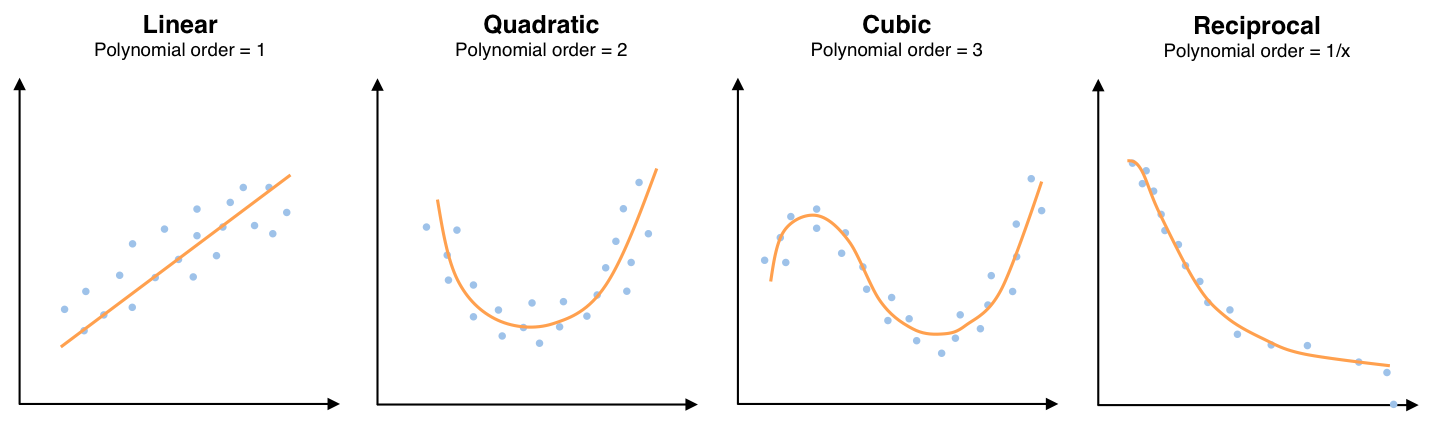

In [ ]:
# The data has changed so we'll recompute the cat and num columns
#cat_cols_train, num_cols_train = get_cat_num_df(train)
#cat_cols_test, num_cols_test = get_cat_num_df(test)

- This list was built manually.
- The EDA analysis done under `Features analysis` helped us fill the explainers listed in `columns_to_transform`.
- Those under the `columns_to_log` are feature that need to be normalised in a way or the others. However, we need to make sure that this has not been done already under the section dedicated to skewed features.

In [ ]:
columns_to_log = [ ]

In [ ]:
columns_to_power = ["OverallQual", "GarageCars", "Fireplaces"]

In [ ]:
def logs(df, columns):
    """
    Log the feature.
    
    Attributes
    ----------
    df : pandas dataframe
    columns : list
        List of column name
    
    Returns
    -------
    df : pandas dataframe
        The transform dataframe
    
    The 1.01 is added to avoid issues with small numbers
    
    """
    m = df.shape[1]
    for l in columns:
        df = df.assign(newcol=pd.Series(np.log(1.01+df[l])).values)
        df.columns.values[m] = l + '_log'
        m += 1
    return df

def power(df, columns, powers):
    """
    Create any feature power.
    
    Attributes
    ----------
    df : pandas dataframe
    columns : list
        List of column name
    powers: list of float
        The degree of the desired polynomial
    
    Returns
    -------
    df : pandas dataframe
        The transform dataframe    
    """
    
    m = df.shape[1]
    for l in columns:
        for power_temp in powers:
            df = df.assign(newcol=pd.Series(df[l]**power_temp).values)
            df.columns.values[m] = l + '_deg_' + str(power_temp)
            m += 1
    return df

def one_over(df, columns):
    """
    Create any feature power.
    
    Attributes
    ----------
    df : pandas dataframe
    columns : list
        List of column name

    Returns
    -------
    df : pandas dataframe
        The transform dataframe    
    """
    
    m = df.shape[1]
    for l in columns:
        # We'll add a small number to avoid dividing by small number
        # which will lead to infinite result
        df = df.assign(newcol=pd.Series(1/(0.001+df[l])).values)
        df.columns.values[m] = l + '_one_over'
        m += 1
    return df

- Only those that were originally tagged as numerical.
- Essentially, we have to exclude those that were hot encoded.
- The power values we are using are as follows:
    - `2` for a quadratic relationship as in `x^2`
    - `3` for a cubic relationship as in `x^3`
    - `0.5=1/2` for a squared root relationship as in `np.sqrt(x)`
    - `-1` for an inverse relationship as in `1/x`
- **WARNING**: pay attention to what to power because if the number are really big alread then you may get an error like this: `ValueError: Input contains NaN, infinity or a value too large for dtype('float32').` This is especially true if work with regression trees ins scikit-leanr.

In [ ]:
# ATTENTION, do we need to log again? has the box-cox transform already done the job?

# We do not want to touch the target column
#train_ = logs(train, columns_to_log)
train_ = power(train_, columns_to_power, [0.5, 2, 3])
#train_ = one_over(train_, columns_to_power)

#test_ = logs(test, columns_to_power)
test_ = power(test_, columns_to_power, [0.5, 2, 3])
#test_ = one_over(test_, columns_to_power)

dsp(train_.shape)
dsp(test_.shape)

In [ ]:
# ATTENTION one over is not used because we need to find a way to deal with infinite and NaN!

In [ ]:
train = train_
test = test_

# Features selection

- The reason why we are doing this here is again to make sure, we are getting the real information out of this step.
- In fact we have done two important operation: 1) imputation and 2) feature engineering. It means the explainers are now different than the original dataset.
- If we had done this at the beggining we'd have lost part of the information added later one.

- [House Prices - EDA Stacking XGB LGB](https://www.kaggle.com/squarex/house-prices-eda-stacking-xgb-lgb#Baseline-model) Very interesting analysis on how to compute the correlation for numerical, categorical and the mix of the two.

## Numerical features

- Heatmap is an excellent way to identify whether there is multicollinearity or not. If you are using linear mode, the best way to solve multicollinearity is to use regularisation methods like Ridge or Lasso.
- Find out correlation between numeric features and SalePrice and select features with correlation >0.2 for modeling.
- Remember that you can also do the same thing for categorical features but you need to encode it. We'll show it later.
- **Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear.**

In [ ]:
num_cols_train = train.select_dtypes(exclude=['object'])
corr = num_cols_train.corr()
plt.figure(figsize=(15, 15))
rcParams['font.size'] = 20
plt.title('Numeric Feature Correlation of Sale Price', fontsize=18)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='RdYlBu',
            linewidths=0.2, annot_kws={'size': 2}, mask=mask,  fmt='.0%', vmin=-1, vmax=1)
plt.show()

- The correlation plot above cannot be read very well.
- We can mask most of the entry like this.

In [ ]:
plt.figure(figsize=(15, 15))
plt.title('Numeric Feature Correlation of Sale Price', fontsize=18)
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], annot=True, cmap='RdYlBu',
            linewidths=0.2, annot_kws={'size': 2}, mask=mask,  fmt='.0%', vmin=-1, vmax=1)
plt.show()

- As we can see, the multicollinearity still exists in various features. However, we will keep them for now for the sake of learning and let the models(e.x. Regularization models such as Lasso, Ridge) do the clean up later on. Let's go through some of the correlations that still exists.

    - There is 0.83 or 83% correlation between GarageYrBlt and YearBuilt.
    - 83% correlation between TotRmsAbvGrd and GrLivArea.
    - 89% correlation between GarageCars and GarageArea.
    - Similarly many other features such asBsmtUnfSF, FullBath have good correlation with other independent feature.

- If I were using only multiple linear regression, I would be deleting these features from the dataset to fit better multiple linear regression algorithms. However, we will be using many algorithms as scikit learn modules makes it easy to implement them and get the best possible outcome. Therefore, we will keep all the features for now.
- Credit to [reference](https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing/notebook)

In [ ]:
plt.figure(figsize=(8, 25))
rcParams['font.size'] = 20
heatmap = sns.heatmap(corr[['SalePrice']].sort_values(
    by='SalePrice', ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdYlBu',
    annot_kws={'size': 15})
heatmap.set_title('Features Correlating with Sales Price',
                  fontdict={'fontsize': 20}, pad=16)

- **WARNING** Although we set outself up to look for all possible and best features possible. Look at what is happening here: feature `GarageCars` when power to 2 and 3 seems to have a very nice colleration with the SalePrice. However, if naively take the top 20 we may take feature that are highly correlated to each otehr and this may confuses the model.

In [ ]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice[corr.SalePrice>0.2])

In [ ]:
pd.DataFrame(corr["SalePrice"]).T

In [ ]:
plt.figure(figsize=(15, 15))
rcParams['font.size'] = 15
sns.barplot(data=pd.DataFrame(corr["SalePrice"]).T, orient='h')
#sns.barplot(x = "SalePrice", data=corr, orient='h')
plt.axvline(x=0.2, color='k', linestyle='-', lw=3, label='Reference line')
plt.axvline(x=-0.2, color='k', linestyle='-', lw=3)

plt.title("Numeric Features' Correlation for Sale Price")
plt.xlabel('Corrlelation')
plt.ylabel('Numeric Features')
plt.show()

- Select all the feature that have a correlation higher than 0.2
- Please note we have used `abs()` which means we are selection all above 0.2 as well as those below -0.2

In [ ]:
corrmat = train.corr()
top_numeric_features = corrmat.index[abs(corrmat["SalePrice"]) > 0.2]
plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(top_numeric_features, dtype=bool))
g = sns.heatmap(train[top_numeric_features].corr(),
                annot=True, cmap="RdYlGn", mask=mask, fmt='.0%', vmin=-1, vmax=1, linewidths=0.2,
                annot_kws={'size': 5})

In [ ]:
top_numeric_features

- **REPEATING THE PREVIOUS WARNING** Although we set outself up to look for all possible and best features possible. Look at what is happening here: feature GarageCars when power to 2 and 3 seems to have a very nice colleration with the SalePrice. However, if naively take the top 20 we may take feature that are highly correlated to each otehr and this may confuses the model.
- Therefore here we remove the repeated ones and we keep that we the highest correlation.
- Here is a list of duplicated and the most correlated one:
    - Fireplaces_deg_0.5
    - GarageCars
    - OverallQual

In [ ]:
set(top_numeric_features)

In [ ]:
top_numeric_features = top_numeric_features.drop(["Fireplaces", 
                                                  "Fireplaces_deg_2", 
                                                  "Fireplaces_deg_3",
                                                  "GarageCars_deg_0.5",
                                                  "GarageCars_deg_2",
                                                  "GarageCars_deg_3",
                                                  "OverallQual_deg_0.5",
                                                  "OverallQual_deg_2",
                                                  "OverallQual_deg_3"
                                                 ])

In [ ]:
set(top_numeric_features)

- Show the most correlated feature by box plot.
- In this case we'll consider the most correlated one and show how by increasing the `OverQual` the price changes.

In [ ]:
print(corr.SalePrice[corr.SalePrice>0.2])

In [ ]:
corr.SalePrice[corr.SalePrice>0.2].index

- We are plotting only those variables that have a low cardinality otherwie the plotting would take too long.

In [ ]:
def plot_box_stripplot_violin_plots(df, features, y):
    """Plot how the target varies wrt to feature chanegs.
    
    This is achieved via three plots:
    [1] box plot :
    [2] stro plot :
    [3] violin plot : 
    [4] bar plot :  A bar plot represents an estimate of central 
    tendency for a numeric variable with the height of each rectangle
    ]and provides some indication of the uncertainty around that 
    estimate using error bars.
    
    Parameters
    ----------
    features : list of string
        List of features name
        
    y : string
        The target variable name
    
    Returns
    -------
    None
    """

    for i in features:
        rcParams['font.size'] = 20
        if i != "SalePrice":            
            fig, ax = plt.subplots(4, 1, figsize=(20, 15))
            sns.boxplot(data=df, x=i, y=y, ax=ax[0])
            sns.stripplot(data=df, x=i, y=y, ax=ax[1])
            sns.violinplot(data=df, x=i, y=y, ax=ax[2])
            sns.barplot(x=i, y=y, data=df, ax=ax[3])
            plt.tight_layout()
            plt.show()

In [ ]:
features = ["GarageCars", "Total_Bathrooms", "TotRmsAbvGrd", "Fireplaces"]
#features = corr.SalePrice[corr.SalePrice>0.2].index
y = "SalePrice"
plot_box_stripplot_violin_plots(train, features, y)

In [ ]:
def plot_reg_plot(features, y_target, df):
    """
    """

    for i in features:

        plt.figure(figsize=(12, 6))
        sns.regplot(data=df, x=i,
                    y=y_target, scatter_kws={'alpha': 0.2})
        plt.title('Regression plot btw OverallQual and SalePrice', fontsize=12)
        plt.show()

In [ ]:
#features = ["OverallQual", "HalfBath"]
y = "SalePrice"
plot_reg_plot(features, y, train)

## Mutual Info

- Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. 
- It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
- **F-test vs. mutual information**: F-test captures only linear dependency, whereas mutual information can capture any kind of dependency between variables.
- More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def show_mi(X, y=y, clean=False):
    if clean:
        X = force_clean(X)
    
    columns_discrete = X.select_dtypes(['object', 'category'])
    discrete_features = X.columns.isin(columns_discrete)
    
    mi = mutual_info_regression(X, y,
                                random_state=12,
                                discrete_features=discrete_features)

    s = pd.Series(mi, index=X.columns, name='mutual_info_regression')\
          .sort_values(ascending=False)
          
    return s, s.to_frame().style.bar()

In [ ]:
s, mi = show_mi(train, train["SalePrice"])

In [ ]:
s

In [ ]:
mi

# Create final dataset

- Create dummy features for categorical values via one-hot encoding.
- It **important** you concatenate the two datasets here before you perform the one-hot-encoding.
- If you are wondering why we are mering the dataset now and then doing some one-hot encoding later. Later is simple: we do not have any other option. In this dataset the train and set have some categorical vairbales where some entries are not present in both sets. For this reason we are "forced" to merge now. If we do not, the two set will end up having different number of columns.

- **Important references on how to merge the train and test data**:
    - [Where the problem lies?](https://www.kaggle.com/questions-and-answers/234176)

- At this point we have the following situation:
    - We have dealt with most of the categorical features, but there is still some of them that need to be hot-encoded. This is the situation were we could not use other type of encoding. One-hot encoding is partiuclar because it does not rank the entry but adds an extra columns. If we have a feature in the train that has 3 distinc entry but the same feature has only two entries in the test set we;ll end up with a different number of columns and this will NOT work.
    - We'll also know we have talked a great deal how to avoid leakage so how do we get out of this?
    
- A solution is what this [reference](https://www.kaggle.com/humananalog/xgboost-lasso) suggested. Essentially, since we now that train and test set are not representative of each other we will:
    - One-hot encode the train set
    - One-hot encode the test set
    - Find out what is present in train set but NOT in test set and **vice-versa**.
    - Remove these from the train set
- **In this way, although we have removed some feature instances, we have essentially leaking info.**

In [ ]:
# Get an idea of the remaining categorical variable
cat_cols_train, num_cols_train = get_cat_num_df(train)
cat_cols_test, num_cols_test = get_cat_num_df(test)

In [ ]:
cat_cols_train.columns

In [ ]:
cat_cols_test.columns

In [ ]:
# From this print out we can see that there are some entries that are not commonly 
# shared between test and train sets
for i in cat_cols_train.columns:
    print("*********************")
    print("Analysing feature:", i)
    print("Present in TRAIN but not in TEST:", get_non_common_values(train[i], test[i]))
    print("Present in TEST but not in TRAIN:", get_non_common_values(test[i], train[i]))
    

In [ ]:
# At this point, we'll proceed with two distinct encoding
#train_ = pd.get_dummies(train)
#test_ = pd.get_dummies(test)

In [ ]:
# Get an idea of the remaining categorical variable
#cat_cols_train_, num_cols_train_ = get_cat_num_df(train_)
#cat_cols_test_, num_cols_test_ = get_cat_num_df(test_)

In [ ]:
#num_cols_train_.columns

In [ ]:
def get_non_common_columns(df1, df2):
    """Get non common values.

    Given two dataframes, df1 and df2, find the values
    that are not common. This is the union of value that
    are in df1 but not in df2 and viceversa.
    """
    # Get values that are in df1 but not in df2
    a = set((df1.columns).difference(df2.columns))
    # Get values that are in df2 but not in df1
    b = set((df2.columns).difference(df1.columns))    
    return a.difference(b)

In [ ]:
# From this print out we can see that there are some entries that are not commonly 
# shared between test and train sets

print("Present in TRAIN but not in TEST:\n", get_non_common_columns(train_, test_))
print("Present in TEST but not in TRAIN:\n", get_non_common_columns(test_, train_))    

In [ ]:
#a_minus_target = list(get_non_common_columns(train_, test_))
#a_minus_target.remove("SalePrice")

In [ ]:
#train_ = train_.drop(columns = a_minus_target)
#test_ = test_.drop(columns = list(get_non_common_columns(test_, train_)))

In [ ]:
#train = train_
#test = test_

- The dimensions now match, meanining we have the same number of columns/explainers. 
- The extra column is due to the target variables.
- Please note how we have less entries than the original dataset for the train set but nothing changes for the test set.

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
print("Before feature selection:", train.shape)
df_train = train[top_numeric_features]
print("After feature selection:", df_train.shape)

print("Before feature selection:", test.shape)
df_test = test[top_numeric_features.drop("SalePrice")]
print("After feature selection:", df_test.shape)

In [ ]:
print(train.shape, df_train.shape)
print(test.shape, df_test.shape)

In [ ]:
df_train["SalePrice"]

In [ ]:
# Some extra additional check
get_missing_values(df_train, sort_by="Feature")

In [ ]:
get_missing_values(df_test, sort_by="Feature")

In [ ]:
df_train.describe()

In [ ]:
df_train

# Save cleaned dataset

In [ ]:
print(train.shape, df_train.shape)
print(test.shape, df_test.shape)

In [ ]:
#df_train["ID"] = Id_train
df_test["ID"] = Id_test

In [ ]:
df_test.shape

In [ ]:
df_train.to_csv("train_clean.csv", index=False)
df_test.to_csv("test_clean.csv", index=False)

In [ ]:
!ls

# Major lessons learnt

- There situation where deciding how to use a feature **logged as a number** as a numerical or categorical one is not so straightforward owening to the fact that both choices work well and the differences are very small.
- Being at least aware of the difference between train and test data is important, especially when we are asking outself if the CV results are representative for predicting the model performance on the test set.